# Lending Club Data Credit Risk Analysis - Predizione dei Default



Lending Club è il più grande mercato di prestiti online.

Lo scopo dell'analisi è usare modelli di machine learning per modellare il rischio di credito come un problema di classificazione binaria. La perdita di credito del prestito è la quantità di denaro persa dal prestatore quando il mutuatario si rifiuta di pagare.

Il dataset scelto è reperibile al link https://www.kaggle.com/datasets/imsparsh/lending-club-loan-dataset-2007-2011 . 
Il dataset è composto da 111 attributi che caratterizzano ogni prestito emesso dal 2007 al 2011: attributo importante è 'loan-status' che rappresenta lo stato attuale del prestito (corrente, addebitato, interamente pagato), che verra' quindi usato come predizione.


Insieme ai dati è presente un data dictionary che descrive sinteticamente il significato di ciascun attributo e che è riportato nella seguente tabella:

<table style="background-color: #FFFFFF;" width="1000" cellspacing="3" cellpadding="1">
      <colgroup><col style="mso-width-source:userset;mso-width-alt:7850;width:166pt"
          width="221"><span style="color: #000200;"> </span><col style="mso-width-source:userset;mso-width-alt:50346;
 width:1062pt" width="1416"> </colgroup>
      <tbody>
        <tr style="height:15.6pt" height="21">
          <td class="xl67" style="height:15.6pt;width:166pt" height="21" width="221"><b><span
              style="color: #000200;">Feature</span></b></td>
          <td class="xl67" style="width:1062pt" width="1416"><b><span style="color: #000200;">Description</span></b></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt" height="19"><span style="color: #000200;">acc_now_delinq</span></td>
          <td class="xl66" style="border-left:none"><span style="color: #000200;">The
              number of accounts on which the borrower is now delinquent.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">acc_open_past_24mths</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of trades opened in past 24 months.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">addr_state</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The state provided by the
              borrower in the loan application</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">all_util</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Balance
              to credit limit on all trades</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">annual_inc</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The self-reported annual
              income provided by the borrower during registration.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">annual_inc_joint</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">The
              combined self-reported annual income provided by the co-borrowers
              during registration</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">application_type</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Indicates
              whether the loan is an individual application or a joint
              application with two co-borrowers</span></td>
        </tr>
        <tr style="mso-height-source:userset;height:18.0pt" height="24">
          <td class="xl66" style="height:18.0pt;border-top:none" height="24"><span
              style="color: #000200;">avg_cur_bal</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Average
              current balance of all accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">bc_open_to_buy</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Total
              open to buy on revolving bankcards.</span></td>
        </tr>
        <tr style="mso-height-source:userset;height:13.95pt" height="18">
          <td class="xl66" style="height:13.95pt;border-top:none" height="18"><span
              style="color: #000200;">bc_util</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Ratio
              of total current balance to high credit/credit limit for all
              bankcard accounts.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">chargeoff_within_12_mths</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of charge-offs within 12 months</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">collection_recovery_fee</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">post charge off
              collection fee</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">collections_12_mths_ex_med</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Number of collections in
              12 months excluding medical collections</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">delinq_2yrs</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The number of 30+ days
              past-due incidences of delinquency in the borrower's credit file
              for the past 2 years</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">delinq_amnt</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">The
              past-due amount owed for the accounts on which the borrower is now
              delinquent.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">desc</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Loan description provided
              by the borrower</span></td>
        </tr>
        <tr style="mso-height-source:userset;height:13.95pt" height="18">
          <td class="xl66" style="height:13.95pt;border-top:none" height="18"><span
              style="color: #000200;">dti</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">A ratio calculated using
              the borrower’s total monthly debt payments on the total debt
              obligations, excluding mortgage and the requested LC loan, divided
              by the borrower’s self-reported monthly income.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">dti_joint</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">A
              ratio calculated using the co-borrowers' total monthly payments on
              the total debt obligations, excluding mortgages and the requested
              LC loan, divided by the co-borrowers' combined self-reported
              monthly income</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">earliest_cr_line</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The month the borrower's
              earliest reported credit line was opened</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">emp_length</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Employment length in
              years. Possible values are between 0 and 10 where 0 means less
              than one year and 10 means ten or more years.<span style="mso-spacerun:yes">&nbsp;</span></span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">emp_title</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The job title supplied by
              the Borrower when applying for the loan.*</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">funded_amnt</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The total amount
              committed to that loan at that point in time.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">funded_amnt_inv</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The total amount
              committed by investors for that loan at that point in time.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">grade</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">LC assigned loan grade</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">home_ownership</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The home ownership status
              provided by the borrower during registration. Our values are:
              RENT, OWN, MORTGAGE, OTHER.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">id</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">A unique LC assigned ID
              for the loan listing.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">il_util</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Ratio
              of total current balance to high credit/credit limit on all
              install acct</span></td>
        </tr>
        <tr style="mso-height-source:userset;height:18.0pt" height="24">
          <td class="xl66" style="height:18.0pt;border-top:none" height="24"><span
              style="color: #000200;">initial_list_status</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The initial listing
              status of the loan. Possible values are – W, F</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">inq_fi</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of personal finance inquiries</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">inq_last_12m</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of credit inquiries in past 12 months</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">inq_last_6mths</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The number of inquiries
              in past 6 months (excluding auto and mortgage inquiries)</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">installment</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The monthly payment owed
              by the borrower if the loan originates.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">int_rate</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Interest Rate on the loan</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">issue_d</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The month which the loan
              was funded</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">last_credit_pull_d</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The most recent month LC
              pulled credit for this loan</span></td>
        </tr>
        <tr style="mso-height-source:userset;height:16.05pt" height="21">
          <td class="xl66" style="height:16.05pt;border-top:none" height="21"><span
              style="color: #000200;">last_pymnt_amnt</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Last total payment amount
              received</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">last_pymnt_d</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Last month payment was
              received</span></td>
        </tr>
        <tr style="mso-height-source:userset;height:16.05pt" height="21">
          <td class="xl66" style="height:16.05pt;border-top:none" height="21"><span
              style="color: #000200;">loan_amnt</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The listed amount of the
              loan applied for by the borrower. If at some point in time, the
              credit department reduces the loan amount, then it will be
              reflected in this value.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">loan_status</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Current status of the
              loan</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">max_bal_bc</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Maximum
              current balance owed on all revolving accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">member_id</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">A unique LC assigned Id
              for the borrower member.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mo_sin_old_il_acct</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Months
              since oldest bank installment account opened</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mo_sin_old_rev_tl_op</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Months
              since oldest revolving account opened</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mo_sin_rcnt_rev_tl_op</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Months
              since most recent revolving account opened</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mo_sin_rcnt_tl</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Months
              since most recent account opened</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mort_acc</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of mortgage accounts.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mths_since_last_delinq</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The number of months
              since the borrower's last delinquency.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mths_since_last_major_derog</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Months
              since most recent 90-day or worse rating</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mths_since_last_record</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The number of months
              since the last public record.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mths_since_rcnt_il</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Months
              since most recent installment accounts opened</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mths_since_recent_bc</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Months
              since most recent bankcard account opened.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mths_since_recent_bc_dlq</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Months
              since most recent bankcard delinquency</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mths_since_recent_inq</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Months
              since most recent inquiry.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">mths_since_recent_revol_delinq</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Months
              since most recent revolving delinquency.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">next_pymnt_d</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Next scheduled payment
              date</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_accts_ever_120_pd</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of accounts ever 120 or more days past due</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_actv_bc_tl</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of currently active bankcard accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_actv_rev_tl</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of currently active revolving trades</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_bc_sats</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of satisfactory bankcard accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_bc_tl</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of bankcard accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_il_tl</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of installment accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_op_rev_tl</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of open revolving accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_rev_accts</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of revolving accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_rev_tl_bal_gt_0</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of revolving trades with balance &gt;0</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_sats</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of satisfactory accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_tl_120dpd_2m</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of accounts currently 120 days past due (updated in past 2 months)</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_tl_30dpd</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of accounts currently 30 days past due (updated in past 2 months)</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_tl_90g_dpd_24m</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of accounts 90 or more days past due in last 24 months</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">num_tl_op_past_12m</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of accounts opened in past 12 months</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">open_acc</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The number of open credit
              lines in the borrower's credit file.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">open_acc_6m</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of open trades in last 6 months</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">open_il_12m</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of installment accounts opened in past 12 months</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">open_il_24m</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of installment accounts opened in past 24 months</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">open_il_6m</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of currently active installment trades</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">open_rv_12m</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of revolving trades opened in past 12 months</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">open_rv_24m</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of revolving trades opened in past 24 months</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">out_prncp</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Remaining outstanding
              principal for total amount funded</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">out_prncp_inv</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Remaining outstanding
              principal for portion of total amount funded by investors</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">pct_tl_nvr_dlq</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Percent
              of trades never delinquent</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">percent_bc_gt_75</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Percentage
              of all bankcard accounts &gt; 75% of limit.</span></td>
        </tr>
        <tr style="height:28.8pt" height="38">
          <td class="xl66" style="height:28.8pt;border-top:none" height="38"><span
              style="color: #000200;">policy_code</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">publicly available
              policy_code=1<br>
              new products not publicly available policy_code=2</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">pub_rec</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Number of derogatory
              public records</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">pub_rec_bankruptcies</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of public record bankruptcies</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">purpose</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">A category provided by
              the borrower for the loan request.<span style="mso-spacerun:yes">&nbsp;</span></span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">pymnt_plan</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Indicates if a payment
              plan has been put in place for the loan</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">recoveries</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">post charge off gross
              recovery</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">revol_bal</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Total credit revolving
              balance</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">revol_util</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Revolving line
              utilization rate, or the amount of credit the borrower is using
              relative to all available revolving credit.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">sub_grade</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">LC assigned loan subgrade</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">tax_liens</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of tax liens</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">term</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The number of payments on
              the loan. Values are in months and can be either 36 or 60.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">title</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The loan title provided
              by the borrower</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">tot_coll_amt</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Total
              collection amounts ever owed</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">tot_cur_bal</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Total
              current balance of all accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">tot_hi_cred_lim</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Total
              high credit/credit limit</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_acc</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">The total number of
              credit lines currently in the borrower's credit file</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_bal_ex_mort</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Total
              credit balance excluding mortgage</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_bal_il</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Total
              current balance of all installment accounts</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_bc_limit</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Total
              bankcard high credit/credit limit</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_cu_tl</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Number
              of finance trades</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_il_high_credit_limit</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Total
              installment high credit/credit limit</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_pymnt</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Payments received to date
              for total amount funded</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_pymnt_inv</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Payments received to date
              for portion of total amount funded by investors</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_rec_int</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Interest received to date</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_rec_late_fee</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Late fees received to
              date</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_rec_prncp</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Principal received to
              date</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">total_rev_hi_lim</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Total
              revolving high credit/credit limit</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">url</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">URL for the LC page with
              listing data.</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">verification_status</span></td>
          <td class="xl65" style="border-top:none;border-left:none;width:1062pt"
            width="1416"><span style="color: #000200;">Indicates if income was
              verified by LC, not verified, or if the income source was verified</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">verified_status_joint</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">Indicates
              if the co-borrowers' joint income was verified by LC, not
              verified, or if the income source was verified</span></td>
        </tr>
        <tr style="height:14.4pt" height="19">
          <td class="xl66" style="height:14.4pt;border-top:none" height="19"><span
              style="color: #000200;">zip_code</span></td>
          <td class="xl66" style="border-top:none;border-left:none"><span style="color: #000200;">The
              first 3 numbers of the zip code provided by the borrower in the
              loan application.</span></td>
        </tr>
      </tbody>
    </table>

## Table of Content
- **Caricamento dataset**

- **Data Exploration**
    - Rimozione colonne con uno o zero valori
    - Rimozione righe con +50% di valori NaN
    - Rimozione colonne non utili manualmente
    - Parsing features numeriche
    - Parsing features categoriche
    - Correlazione
    $$$$
- **Preprocessamento**
    - Imputazione dei NaN
    - Individuazione degli outliers
        - Outlier Detection and Removal Univariato
        - Outlier Detection and Removal Multivariato
    - Scaling
    - Bilanciamento delle classi
    - Dimensionality reduction
    $$$$
- **Processamento**
    - Scelta della metrica
    - Classificazione
    $$$$
- **Conclusione**
    - Conclusioni

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as model_selection
from dataCleaner import dataCleaner
from BornAgainTree import BornAgainTree
import itertools

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, plot_confusion_matrix

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import iqr
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

## Caricamento dataset

In [2]:
#Caricamento del dataset
#-----------------------------------------------------------------------------------------------------------------------------
data = pd.read_csv('loan.csv', low_memory=False)
print("Shape:", data.shape)
data.head()

Shape: (39717, 111)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
#Etichetta
#-----------------------------------------------------------------------------------------------------------------------------
data.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

Si è interessati a predire, data una richiesta di prestito, se quel prestito verra' interamente pagato oppure no. Di conseguenza si dovranno scartare le osservazioni con stato del prestito 'Current'.

In [4]:
data = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]

In [5]:
data.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Name: loan_status, dtype: int64

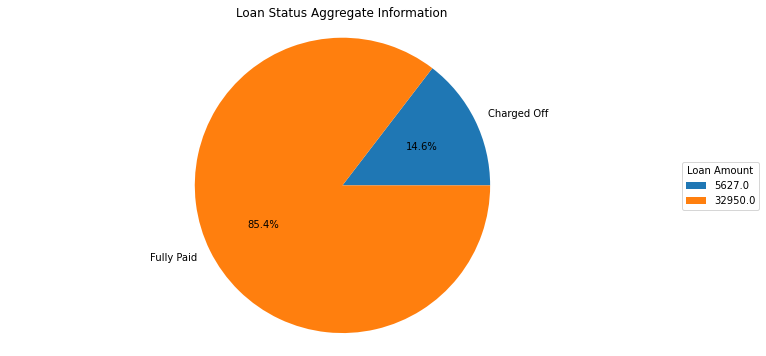

In [6]:
# Pie Plot per i tipi differenti di loan_status
#-----------------------------------------------------------------------------------------------------------------------------
loans_sum  = [{"Charged Off": (data["loan_status"] == "Charged Off").sum(),"Fully Paid":(data["loan_status"] == "Fully Paid").sum()}]
investment_sum = pd.DataFrame(loans_sum) 
chargedOffTotalSum = float(investment_sum["Charged Off"])
fullyPaidTotalSum = float(investment_sum["Fully Paid"])
loan_status = [chargedOffTotalSum,fullyPaidTotalSum]
loan_status_labels = 'Charged Off','Fully Paid'
fig, ax = plt.subplots(figsize = (12,6))
plt.pie(loan_status,labels=loan_status_labels,autopct='%1.1f%%')
plt.title('Loan Status Aggregate Information')
plt.axis('equal')
plt.legend(loan_status,title="Loan Amount",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
fig.set_facecolor('white')
plt.show()

Effettuiamo lo split training-test secondo la proporzione 80%-20%

In [7]:
#Train-Test Split 80/20
#-----------------------------------------------------------------------------------------------------------------------------
columns = data.columns
features = columns.drop('loan_status')
target = ['loan_status']
x = data[features]
y = data[target]

train_x, raw_test_x, train_y, raw_test_y = model_selection.train_test_split(x, y, test_size=0.2, random_state=0)
dataCleaner = dataCleaner()

In [8]:
#Codifica Label: 0 <--> Prestito completamente ripagato (guadagno) | 1 <--> Prestito addebitato (perdita)
#-----------------------------------------------------------------------------------------------------------------------------
loan_status_dict = {'Fully Paid':0, 'Charged Off':1}
dataCleaner.set_target_mapDict(loan_status_dict)
dataCleaner.encode_target(train_y)

c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\pandas\core\frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
train_y['loan_status'].head(10)

39069    0.0
29191    1.0
6560     0.0
35167    0.0
4230     0.0
20573    0.0
29114    0.0
30697    0.0
2720     0.0
14932    0.0
Name: loan_status, dtype: float64

In [10]:
#Numero di features
#-----------------------------------------------------------------------------------------------------------------------------
len(train_x.columns)

110

## Data Exploration

### Rimozione colonne unico valore univoco

In [11]:
"""Ritorna una lista che corrisponde all'insieme dei valori (non ripetuti) estratti dalla colonna dfCol non considerando i valori nulli"""
def unique_non_null(dfCol):
    return dfCol.dropna().unique()

Si eliminano tutte le colonne che hanno un solo valore su tutte le osservazioni

In [12]:
colNotUniqueValue = []
for col in train_x.columns:
    colUniqueValuesCount = len(unique_non_null(data[col]))
    if colUniqueValuesCount > 1:
        colNotUniqueValue.append(col)
    print("{:<30} {:<15}".format( col, colUniqueValuesCount))

id                             38577          
member_id                      38577          
loan_amnt                      870            
funded_amnt                    1019           
funded_amnt_inv                8050           
term                           2              
int_rate                       370            
installment                    15022          
grade                          7              
sub_grade                      35             
emp_title                      28027          
emp_length                     11             
home_ownership                 5              
annual_inc                     5215           
verification_status            3              
issue_d                        55             
pymnt_plan                     1              
url                            38577          
desc                           25803          
purpose                        14             
title                          19297          
zip_code     

In [13]:
train_x = train_x.loc[:, colNotUniqueValue]

In [14]:
#Numero di features con più di 2 valori non nulli
#-----------------------------------------------------------------------------------------------------------------------------
len(train_x.columns) 


44

### Rimozione di righe con +50% di valori NaN

Controlliamo se c'è qualche riga la cui percentuale di NaN supera il 50%

In [15]:
percentageNanInRow = np.ones(len(train_x))*len(train_x.columns)

percentageNanInRow = np.divide((train_x.isna().sum(axis=1)) , percentageNanInRow)
np.max(percentageNanInRow)

0.13636363636363635

Nessuna riga contiene più del 50% di valori nulli, quindi manteniamo tutte le righe

### Rimozione colonne non utili manualmente

Eliminazione delle features non utili alla predizione e separazione delle feature categoriche da quelle numeriche (per l'eliminazione delle features è stato consultato il dizionario dei dati nel file <b>./Data_Dictionary.xlsx</b> riportato in testa a questo notebook)

In [16]:
#Divisione delle features numeriche e categoriche
#-----------------------------------------------------------------------------------------------------------------------------
categorical_features=[]
numerical_features=[]

In [17]:
colIdx = range(0,10)
train_x.iloc[:,colIdx].head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade
39069,272103,270527,10000,10000,3949.809998,36 months,12.92%,336.56,D,D2
29191,525686,680144,8400,8400,8395.979770,60 months,17.93%,212.99,E,E5
6560,893159,1110314,7425,7425,7400.000000,36 months,6.03%,225.99,A,A1
35167,439837,531893,10000,10000,9975.000000,36 months,14.26%,343.06,C,C5
4230,1006067,1232469,4625,4625,4625.000000,36 months,12.42%,154.55,B,B4
20573,656937,840178,4000,4000,3975.000000,36 months,10.37%,129.77,B,B3
29114,527001,681702,3000,3000,2840.375550,36 months,7.14%,92.83,A,A3
30697,503073,647309,2575,2575,2575.000000,36 months,6.76%,79.24,A,A2
2720,1032357,1262020,13000,13000,13000.000000,60 months,19.42%,340.24,E,E3
14932,752830,952448,30000,25675,25650.000000,60 months,19.69%,675.81,E,E5


<b>Attributi scartati:</b>

*id* e *member_id*: codici identificativi non utili per la predizione

*funded_amnt* e *funded_amnt_inv*: attributi che non sono disponibili al momento della scelta se effettuare il prestito o no

*grade* e *sub_grade*: attributi in stretta dipendenza con la feature *int_rate*


In [18]:
#Attributi mantenuti
categorical_features.append('term')
numerical_features.append('loan_amnt')
numerical_features.append('installment')
numerical_features.append('int_rate')

In [19]:
colIdx = range(10,20)
train_x.iloc[:,colIdx].head(10)

,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,url,desc,purpose,title
39069,Lithia Motors Inc.,4 years,RENT,37200.0,Not Verified,Mar-08,https://lendingclub.com/browse/loanDetail.acti...,"Friends and Members of this Community, Thank ...",debt_consolidation,Steps To Success
29191,Good Samaritan village,10+ years,MORTGAGE,20000.0,Source Verified,Jun-10,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 06/07/10 > This loan is to...,major_purchase,car finisher
6560,the citadel,10+ years,MORTGAGE,65000.0,Source Verified,Oct-11,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 09/25/11 > pay off high in...,debt_consolidation,Debt Consolidation Loan
35167,MySpace,1 year,RENT,130000.0,Verified,Sep-09,https://lendingclub.com/browse/loanDetail.acti...,I have a guaranteed bonus of 10k end of this y...,credit_card,consolidate 3 credit card to 1
4230,Asplundh Tree Expert Company,4 years,MORTGAGE,40000.0,Not Verified,Nov-11,https://lendingclub.com/browse/loanDetail.acti...,NaN,medical,Medicals
20573,Philips,4 years,MORTGAGE,154000.0,Verified,Jan-11,https://lendingclub.com/browse/loanDetail.acti...,NaN,moving,home moving
29114,sisley/ gap,5 years,RENT,40000.0,Not Verified,Jun-10,https://lendingclub.com/browse/loanDetail.acti...,NaN,vacation,europe
30697,NaN,3 years,RENT,82500.0,Not Verified,Apr-10,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 04/14/10 > I'm applying to...,educational,Harvard Summer School
2720,Progressive Insurance,< 1 year,RENT,37500.0,Source Verified,Dec-11,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,goodbye ccs
14932,US Customs & Border Protection,10+ years,MORTGAGE,138000.0,Verified,May-11,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 05/15/11 > Will use this m...,home_improvement,Pool Loan


<b>Attributi scartati:</b>

*emp_title* e *issue_d*: attributi non utili per la predizione

*loan_status*: attributo sul quale di vuole effettuare la predizione

*url* e *desc*: attributi non utili per la predizione


In [20]:
categorical_features.append('home_ownership')
categorical_features.append('purpose')
categorical_features.append('verification_status')
numerical_features.append('emp_length')
numerical_features.append('annual_inc')

In [21]:
colIdx = range(20,30)
train_x.iloc[:,colIdx].head(10)

,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec
39069,975xx,OR,6.74,0,Jan-01,0,72.0,0.0,7,0
29191,561xx,MN,4.20,0,Apr-06,1,26.0,NaN,6,0
6560,294xx,SC,19.40,0,Dec-90,1,NaN,NaN,10,0
35167,900xx,CA,7.50,2,Aug-02,3,10.0,NaN,7,0
4230,660xx,KS,5.70,0,Aug-93,1,NaN,NaN,4,0
20573,891xx,NV,13.62,1,Aug-91,3,18.0,NaN,15,0
29114,069xx,CT,23.40,0,Apr-03,1,NaN,NaN,16,0
30697,021xx,MA,4.80,0,Nov-97,2,NaN,NaN,6,0
2720,554xx,MN,9.82,0,Nov-02,0,NaN,NaN,6,0
14932,923xx,CA,5.99,1,Dec-94,0,23.0,NaN,12,0


<b>Attributi scartati:</b>

*title*, *zip_code*, *addr_state*: attributi che risultano non essere correlati con la predizione

*mths_since_last_delinq* e *mths_since_last_record*: attributi che non sono disponibili al momento della scelta se effettuare il prestito o no

In [22]:
numerical_features.append('delinq_2yrs')
numerical_features.append('earliest_cr_line')
numerical_features.append('open_acc')
numerical_features.append('inq_last_6mths')
numerical_features.append('dti')

In [23]:
colIdx = range(30,len(train_x.columns))
train_x.iloc[:,colIdx].head(10)

,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
39069,7067,65.80%,8,12115.923500,4745.48,10000.00,2115.92,0.0,0.00,0.00,Mar-11,340.83,Mar-11,NaN
29191,2239,48.70%,9,3714.700000,3705.20,1563.53,1834.55,0.0,316.62,3.31,Oct-11,212.99,Mar-12,0.0
6560,21626,35.20%,19,8094.328222,8067.07,7425.00,669.33,0.0,0.00,0.00,Sep-14,193.70,Sep-14,0.0
35167,12907,52.90%,24,10459.671770,10433.52,10000.00,459.67,0.0,0.00,0.00,Jan-10,9433.44,Apr-16,0.0
4230,2240,17.60%,21,5563.609683,5563.61,4625.00,938.61,0.0,0.00,0.00,Nov-14,168.04,May-16,0.0
20573,16220,61.60%,29,4671.219641,4642.02,4000.00,656.22,15.0,0.00,0.00,Sep-13,766.11,May-16,0.0
29114,4110,9.20%,22,3353.810836,3164.53,3000.00,338.81,15.0,0.00,0.00,Mar-13,374.98,Mar-13,0.0
30697,4678,21.70%,29,2828.300113,2828.30,2575.00,253.30,0.0,0.00,0.00,Jul-12,853.04,Jul-12,0.0
2720,11242,89.90%,9,19086.739980,19086.74,13000.00,6086.74,0.0,0.00,0.00,Jan-15,6848.73,Dec-15,0.0
14932,9177,40.20%,30,35643.215700,35608.51,25675.00,9968.22,0.0,0.00,0.00,Oct-13,17412.40,May-16,0.0


<b>Attributi scartati:</b>

*total_acc*, *total_pymnt* e *total_pymnt_inv*,

*total_rec_prncp*, *total_rec_int*, *total_rec_late_fee*: attributi che non sono disponibili al momento della scelta se effettuare il prestito o no

*recoveries* e *collection_recovery_fee*: attributi non utili per la predizione

*last_pymnt_d* e *last_pymnt_amnt*: attributi che non sono disponibili al momento della scelta se effettuare il prestito o no


In [24]:
numerical_features.append('pub_rec')
numerical_features.append('revol_util')
numerical_features.append('revol_bal')
numerical_features.append('last_credit_pull_d')
numerical_features.append('pub_rec_bankruptcies')

In [25]:
train_x_categorical=pd.DataFrame()
for col in categorical_features:
    train_x_categorical=pd.concat([ train_x_categorical, train_x[col]], axis= 1)
    dataCleaner.addFeatureToBeMantained(col)

train_x_categorical.head()

,term,home_ownership,purpose,verification_status
39069,36 months,RENT,debt_consolidation,Not Verified
29191,60 months,MORTGAGE,major_purchase,Source Verified
6560,36 months,MORTGAGE,debt_consolidation,Source Verified
35167,36 months,RENT,credit_card,Verified
4230,36 months,MORTGAGE,medical,Not Verified


In [26]:
train_x_numerical=pd.DataFrame()
for col in numerical_features:
    train_x_numerical=pd.concat([ train_x_numerical, train_x[col]], axis= 1)
    dataCleaner.addFeatureToBeMantained(col)

train_x_numerical.head()


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,pub_rec,revol_util,revol_bal,last_credit_pull_d,pub_rec_bankruptcies
39069,10000,336.56,12.92%,4 years,37200.0,0,Jan-01,7,0,6.74,0,65.80%,7067,Mar-11,NaN
29191,8400,212.99,17.93%,10+ years,20000.0,0,Apr-06,6,1,4.20,0,48.70%,2239,Mar-12,0.0
6560,7425,225.99,6.03%,10+ years,65000.0,0,Dec-90,10,1,19.40,0,35.20%,21626,Sep-14,0.0
35167,10000,343.06,14.26%,1 year,130000.0,2,Aug-02,7,3,7.50,0,52.90%,12907,Apr-16,0.0
4230,4625,154.55,12.42%,4 years,40000.0,0,Aug-93,4,1,5.70,0,17.60%,2240,May-16,0.0


### Parsing features numeriche

In [28]:
#Rimozione del segno di percentuale dalle colonne 'revol_util' e 'int_rate'
#-----------------------------------------------------------------------------------------------------------------------------
featureList = ['revol_util', 'int_rate']
dataCleaner.removePercentageSign(train_x_numerical, featureList)

In [29]:
#Conversione delle date in numeri in quanto se gestite come variabili categoriche avrebbero generato troppe dummy variables
#------------------------------------------------------------------------------------------------------------------------------
featureList = ['last_credit_pull_d', 'earliest_cr_line']
dataCleaner.convertFromDateToInt(train_x_numerical, "%b-%y", featureList)

c:\Users\fabia\MachineLearningProject\dataCleaner.py:46: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data[feature] = pd.DatetimeIndex(data[feature]).astype(np.int64)*1e-9


In [30]:
#Conversione di 'emp_length' in una variabile numerica ordinale
#-------------------------------------------------------------------------------------------------------------------------------
train_x_numerical.emp_length.unique()

array(['4 years', '10+ years', '1 year', '5 years', '3 years', '< 1 year',
       '6 years', '2 years', '7 years', '9 years', '8 years', nan],
      dtype=object)

In [31]:
mapDict = {
    'emp_length': {
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0,
    }
}

dataCleaner.set_emp_length_mapDict(mapDict)
dataCleaner.encode_emp_length(train_x_numerical)

In [32]:
train_x_numerical.head()

,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,pub_rec,revol_util,revol_bal,last_credit_pull_d,pub_rec_bankruptcies
39069,10000,336.56,12.92,4.0,37200.0,0,9.783072e+08,7,0,6.74,0,65.8,7067,1.298938e+09,NaN
29191,8400,212.99,17.93,10.0,20000.0,0,1.143850e+09,6,1,4.20,0,48.7,2239,1.330560e+09,0.0
6560,7425,225.99,6.03,10.0,65000.0,0,6.600096e+08,10,1,19.40,0,35.2,21626,1.409530e+09,0.0
35167,10000,343.06,14.26,1.0,130000.0,2,1.028160e+09,7,3,7.50,0,52.9,12907,1.459469e+09,0.0
4230,4625,154.55,12.42,4.0,40000.0,0,7.441632e+08,4,1,5.70,0,17.6,2240,1.462061e+09,0.0


In [33]:
#Conversione delle variabili numeriche in float
#-------------------------------------------------------------------------------------------------------------------------------
train_x_numerical = dataCleaner.convertToFloat(train_x_numerical)

### Parsing features categoriche

Il parsing per le features categoriche è effettuato attraverso codifica One-hot

In [34]:
for col in train_x_categorical.columns:
    print(col,'\n',train_x_categorical[col].unique(),'\n')

term 
 [' 36 months' ' 60 months'] 

home_ownership 
 ['RENT' 'MORTGAGE' 'OWN' 'OTHER' 'NONE'] 

purpose 
 ['debt_consolidation' 'major_purchase' 'credit_card' 'medical' 'moving'
 'vacation' 'educational' 'home_improvement' 'wedding' 'other'
 'small_business' 'car' 'house' 'renewable_energy'] 

verification_status 
 ['Not Verified' 'Source Verified' 'Verified'] 



In [35]:
#Creazione delle dummy variables tramite codifica One-Hot
#------------------------------------------------------------------------------------------------------------------------------
for col in train_x_categorical.columns:
    dataCleaner.addFeatureToBeOneHotEncoded(col)

#sostituire i valori "NONE" di home_ownership con "" 
train_x_categorical = train_x_categorical.replace('NONE', '')

encoder = OneHotEncoder(drop='first') # rimuovo una variabile dummy per ogni feature categorica in modo da non avere collinearità

encoder.fit(train_x_categorical)
dataCleaner.setOneHotEncoder(encoder)
train_x_categorical = dataCleaner.applyOneHotEncoding(train_x_categorical)

In [36]:
train_x_categorical.head()

,x0_ 60 months,x1_MORTGAGE,x1_OTHER,x1_OWN,x1_RENT,x2_credit_card,x2_debt_consolidation,x2_educational,x2_home_improvement,x2_house,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
39069,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29191,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6560,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35167,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4230,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# combino valori numerici con categorici
train_x = pd.concat([train_x_numerical,train_x_categorical],axis=1)

In [85]:
#Numero di features interessanti ai fini della predizione
#-----------------------------------------------------------------------------------------------------------------------------
len(train_x.columns) 

35

### Correlazione

La correlazione è una misura di relazione tra due variabili: la tendenza di una variabile a cambiare in relazione ad un'altra.

La correlazione puo' essere:
- positiva (o diretta): se una variabile aumenta anche l'altra aumenta.
- negativa (o indiretta): se una aumenta l'altra diminuisce.

Andiamo ad eliminare le features poco correlate con l'output tenendo però presente che queste features vanno cancellate solo se non sono categoriche oppure se, essendo categoriche, tutte le features dummy create con la codifica one-hot risultano poco correlate con l'output.

Stabiliamo che una feature va eliminata qualora la sua correlazione con l'output sia minore ad una threshold posta a $0.01$.


In [38]:
corr = pd.concat([train_x, train_y], axis=1).corr()
corr.iloc[:, len(corr)-1]

loan_amnt                0.059701
installment              0.028754
int_rate                 0.210598
emp_length               0.014855
annual_inc              -0.040839
delinq_2yrs              0.024098
earliest_cr_line         0.019438
open_acc                -0.008633
inq_last_6mths           0.069132
dti                      0.048508
pub_rec                  0.053674
revol_util               0.101614
revol_bal                0.005519
last_credit_pull_d      -0.042360
pub_rec_bankruptcies     0.050069
x0_ 60 months            0.168980
x1_MORTGAGE             -0.025033
x1_OTHER                 0.010702
x1_OWN                   0.004621
x1_RENT                  0.021447
x2_credit_card          -0.045545
x2_debt_consolidation    0.024036
x2_educational           0.000360
x2_home_improvement     -0.021333
x2_house                 0.003391
x2_major_purchase       -0.031104
x2_medical               0.004971
x2_moving                0.002913
x2_other                 0.014255
x2_renewable_e

In [40]:
corr = pd.concat([train_x, train_y], axis=1).corr()
corr_values = corr.iloc[:,len(corr)-1].values
print("Massima correlazione positiva con il target:", np.max(corr_values[0:len(corr_values)-1]))
print("Massima correlazione negativa con il taeget:", np.min(corr_values))
print(pd.concat([train_x, train_y], axis=1).corr().columns[abs(corr_values) < 0.01])  

Massima correlazione positiva con il target: 0.2105979371831843
Massima correlazione negativa con il taeget: -0.04554527233856463
Index(['open_acc', 'revol_bal', 'x1_OWN', 'x2_educational', 'x2_house',
       'x2_medical', 'x2_moving', 'x2_renewable_energy', 'x2_vacation',
       'x3_Source Verified'],
      dtype='object')


Rimuoviamo le features 'open_acc' e 'revol_bal'

In [40]:
toBeRemoved = ['open_acc', 'revol_bal']
train_x.drop(toBeRemoved, inplace=True, axis=1)
dataCleaner.removeFeatureToBeMantained(toBeRemoved)

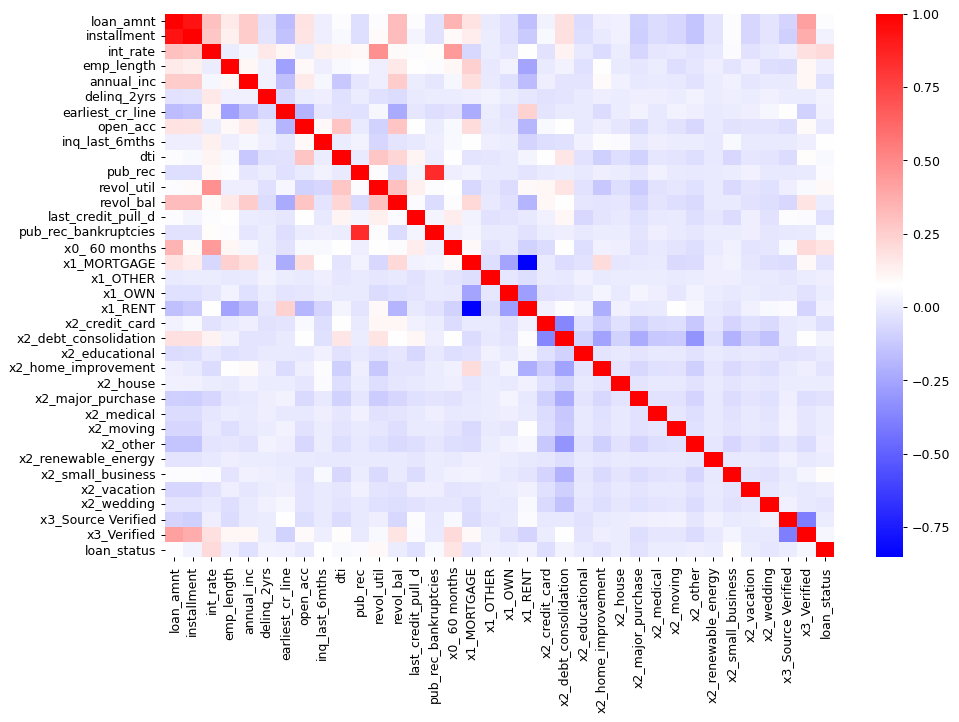

<Figure size 432x288 with 0 Axes>

In [41]:
plt.figure(figsize=(12, 8), dpi=90)
sns.heatmap(pd.concat([train_x, train_y], axis=1).corr(), cmap="bwr")
plt.show()
plt.savefig('correlation.png')

## Preprocessamento

### Imputazione valori NaN (kNN Inputer)

Il riempimento dei valori nulli può essere fatti in diversi modi:
1. un approccio semplice è quello di sostituire il valore nullo con la media (o la moda, in caso di valori categorici) dei valori assunti dalle osservazione sulla feature in questione;
2. un secondo approccio, un po' più elaborato, consiste nel riempire i valori nulli andando a guardare il vicinato di un punto.

Il primo approccio produce valori fortemente biased, ma con varianza nulla; il secondo approccio, invece, produce valori con varianza tipicamente non nulla e con bias tipicamente più basso, "tipicamente" perché il comportamento dipende da quanto si considera grande il vicinato.

<img src="Immagini\K_NN.png" width="400"/>

In questo documento è stato utilizzato il secondo approccio, che tipicamente risulta migliore; il metodo utilizzato si basa su kNN. 
Si specifica un valore k e si predice un valore andando a guardare la media dei valori assunti dai k vicini più vicini; la media dei valori assunti dai vicini è uniforme o ponderata in base alla distanza da ciascun vicino. Nel nostro caso effettuiamo una media con pesi uniformi.
Nel caso in cui il numero k sia pari o maggiore al numero di elementi con valore non nullo sulla caratteristica da riempire, allora il riempimento è effettuato scegliendo la media dei valori assunti dal dataset (come nel primo approccio, ma computazionalmente è molto più oneroso).

Si noti che il riempimento dei valori nulli tramite kNN è equivalente ad una classificazione tramite kNN in cui, anziché predire il valore del target, si predice il valore di una feature.

In [42]:
train_x.isna().sum()

loan_amnt                  0
installment                0
int_rate                   0
emp_length               814
annual_inc                 0
delinq_2yrs                0
earliest_cr_line           0
open_acc                   0
inq_last_6mths             0
dti                        0
pub_rec                    0
revol_util                40
revol_bal                  0
last_credit_pull_d         0
pub_rec_bankruptcies     569
x0_ 60 months              0
x1_MORTGAGE                0
x1_OTHER                   0
x1_OWN                     0
x1_RENT                    0
x2_credit_card             0
x2_debt_consolidation      0
x2_educational             0
x2_home_improvement        0
x2_house                   0
x2_major_purchase          0
x2_medical                 0
x2_moving                  0
x2_other                   0
x2_renewable_energy        0
x2_small_business          0
x2_vacation                0
x2_wedding                 0
x3_Source Verified         0
x3_Verified   

Si effettua imputazione di nan sulle features:

<b>emp_length</b>: la data di occupazione in anni

<b>revol_util</b>: tasso di utilizzo della linea revolving

<b>pub_rec_bankruptcies</b>: Numero di fallimenti di registri pubblici

In [43]:
#imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = KNNImputer(n_neighbors=1, weights="uniform")

train_x[:] = imp.fit_transform(train_x)
dataCleaner.set_imputer(imp)


In [44]:
train_x.isna().sum()

loan_amnt                0
installment              0
int_rate                 0
emp_length               0
annual_inc               0
delinq_2yrs              0
earliest_cr_line         0
open_acc                 0
inq_last_6mths           0
dti                      0
pub_rec                  0
revol_util               0
revol_bal                0
last_credit_pull_d       0
pub_rec_bankruptcies     0
x0_ 60 months            0
x1_MORTGAGE              0
x1_OTHER                 0
x1_OWN                   0
x1_RENT                  0
x2_credit_card           0
x2_debt_consolidation    0
x2_educational           0
x2_home_improvement      0
x2_house                 0
x2_major_purchase        0
x2_medical               0
x2_moving                0
x2_other                 0
x2_renewable_energy      0
x2_small_business        0
x2_vacation              0
x2_wedding               0
x3_Source Verified       0
x3_Verified              0
dtype: int64

### Individuazione degli outliers

Il rilevamento degli outlier (outlier detection) consiste nell'identificazione degli elementi di un dataset che differiscono in modo significativo dagli altri elementi del dataset.

Le tecniche di rilevamento degli outliers possono essere suddivise in approcci univariati o approcci multivariati.

Gli approcci univariati consistono nel considerare una singola feature ed andare ad individuare quali elementi del dataset presentano un valore anomalo per quella feature.

Gli approcci multivariati, invece, considerano contemporaneamente più features e cercano di scovare combinazioni anomale nei valori delle features.

Vediamo un esempio:
<table cellspacing="5", style="background-color: white; color: black" >
      <tbody>
        <tr>
          <td>Nome</td>
          <td>Età</td>
          <td>Altezza (cm)</td>
          <td>Peso (kg)</td>
          <td>Figli</td>
        </tr>
        <tr>
          <td>Maria</td>
          <td style="background-color: #9fc5e8;">10</td>
          <td>134</td>
          <td>42</td>
          <td style="background-color: #9fc5e8;">2<br>
          </td>
        </tr>
        <tr>
          <td>Lucia</td>
          <td>18</td>
          <td>174<br>
          </td>
          <td>60<br>
          </td>
          <td>1<br>
          </td>
        </tr>
        <tr>
          <td>Anna</td>
          <td>16</td>
          <td>164<br>
          </td>
          <td>53<br>
          </td>
          <td>0<br>
          </td>
        </tr>
        <tr>
          <td style="width: 50px;">Paola</td>
          <td style="width: 50px;">20</td>
          <td style="width: 50px; background-color: #f1c232;">270<br>
          </td>
          <td style="width: 50px;">61<br>
          </td>
          <td style="width: 50px;">2<br>
          </td>
        </tr>
        <tr>
          <td>Sofia</td>
          <td>9</td>
          <td>110</td>
          <td>38</td>
          <td>0</td>
        </tr>
        <tr>
          <td>Mara</td>
          <td>8</td>
          <td>102</td>
          <td>34</td>
          <td>0</td>
        </tr>
        <tr>
          <td>Asia</td>
          <td>9</td>
          <td>114</td>
          <td>36</td>
          <td>0</td>
        </tr>
      </tbody>
    </table>

Nel primo caso, in arancione, vediamo che il valore 270 per l'altezza di una persona non è plausibile, dunque possiamo etichettare questo valore come outlier. Si noti che per farlo abbiamo considerato solo l'attributo "Altezza".

Nel secondo caso, in azzurro, nessun valore per gli attributi della prima istanza del dataset sono di per sé allarmanti: in particolare il valore 10 per l'età è perfettamente plausibile, così come lo è il valore 2 in riferimento al numero di figli, tuttavia ciò che è anomalo è che contemporaneamente l'età sia 10 e il numero di figli sia diverso da 0! In questo caso la prima istanza del dataset rappresenta un outlier.


#### Outlier Detection Univariata: IQR Rule

L'approccio univariato all'outlier detection è fatto tramite la interquartile range rule (**IQR Rule**).

Per definizione, il 25% dei valori assunti da un campione cadono al di sotto di Q1 e il 25% cadono al di sopra di Q3. Definiamo questo intervallo come interquartile range $$IQR = Q3 - Q1$$
L'interquartile range rule consiste nel classificare come outliers quei valori che cadono al di fuori di un certo intervallo di decisione definito a partire dall'interquantile range: $$[Q1 - 1.5*IQR, Q3 + 1.5*IQR]$$

La ragione del valore 1.5 si trova con riferimento alla normale standard.

<img src="Immagini\IQR Rule.png" width="400"/>

Per una normale standard pochi valori, $\simeq0.28\%$. è più lontano dalla media di $3\sigma$, dunque vorremmo replicare questa caratteristica scegliendo un opportuno intervallo di decisione.

Come si vede dalla figura precedente Q1 e Q3 corrispondono a circa $\pm0.675\sigma$, dunque l'intervallo $[ Q1 - 1.5 \cdot IQR, Q3 + 1.5 \cdot IQR ]$ diventa:

$$
\begin{aligned}
& [-0.675\sigma - 1.5*(0.675\sigma-(-0.675\sigma)), 0.675\sigma + 1.5*(0.675\sigma-(-0.675\sigma))] =\\
& [-0.675\sigma - 2.025\sigma, 0.675\sigma + 2.025\sigma] =\\
& [ - 2.7\sigma, + 2.7\sigma]\\
\end{aligned}
$$


In [45]:
counter = 0
for col in train_x_numerical.columns:
    iqr_value = iqr(train_x_numerical[col])
    q1 = np.quantile(train_x_numerical[col], 0.25)
    q3 = np.quantile(train_x_numerical[col], 0.75)
    for i in range(0, train_x_numerical.shape[0]):
        if train_x_numerical[col].iloc[i] > (q3+1.5*(iqr_value)) or train_x_numerical[col].iloc[i] < (q1 - 1.5*(iqr_value)):
            counter = counter + 1
    print("{:<30} {:<20}  {:<10}".format(col, counter, counter/train_x_numerical[col].shape[0]))
    counter = 0


loan_amnt                      855                   0.027704870224555263
installment                    1158                  0.037523087391853796
int_rate                       71                    0.0023006383461326592
emp_length                     0                     0.0       
annual_inc                     1473                  0.04773014484300574
delinq_2yrs                    3330                  0.1079031787693205
earliest_cr_line               1125                  0.03645377661125693
open_acc                       404                   0.01309095622306471
inq_last_6mths                 2864                  0.09280321441301319
dti                            0                     0.0       
pub_rec                        1681                  0.0544700430964648
revol_util                     0                     0.0       
revol_bal                      1901                  0.06159878163377726
last_credit_pull_d             57                    0.0018469913483036842
p

Dalla valutazione della quantità di valori che verrebbero considerati outliers tramite la IQR Rule, possiamo constatare che per i dati in nostro possesso questo metodo non risulta essere molto buono per rilevare gli outliers.
Notiamo, infatti, che per diverse features, la percentuale di valori considerati outliers dalla IQR Rule è troppo alta rispetto, per una normale standard il valore è $\pm 0.28\%$, mentre noi ci troviamo features con valori al di sopra del $10\%$.

La ragione di ciò risiede nel fatto che la regola IQR assume che i dati siano distribuiti approssimativamente come una gaussiana. Ora, seppur il metodo è robusto e nella pratica ci accorgiamo che funziona bene anche con distribuzioni leggermente diverse dalla gaussiana, nel nostro caso le distribuzioni sono troppo diverse.

Verifichiamo graficamente la precedente affermazione, andando a graficare i QQ-Plots di ciascuna feature: i dati di un campione sono distribuiti secondo una gaussiana se i punti del QQ-Plot si distribuiscono sulla bisettrice del primo-terzo quadrante.  

c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly 

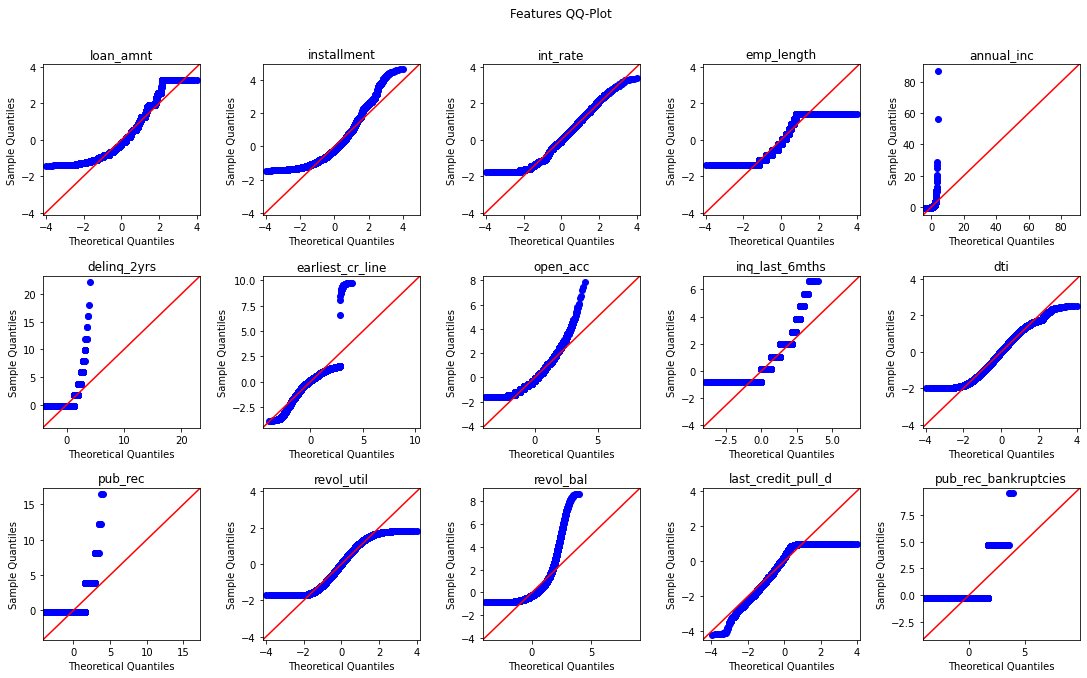

In [46]:
fig, axes = plt.subplots(3, 5, figsize=(18, 10))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.suptitle('Features QQ-Plot')
ax= axes.flatten()
for i in range(0, train_x_numerical.columns.size):
    ax[i].set_title(train_x_numerical.columns[i])
    non_nan_values=train_x_numerical[train_x_numerical.columns[i]].dropna()
    sm.qqplot(non_nan_values, line="45", fit = True, ax=ax[i])


Guardando i QQ-Plots ci rendiamo conto che la maggior parte delle features non hanno distribuzione gaussiana, ma anzi seguono una distibuzione right-skewed (la concavità dei plot è verso l'alto), in particolare ciò è vero per le features che rappresentano processi di conteggio (quelle in cui il plot è a tratti) come: *delinq_2yrs* e *inq_last_6_mths* che contano rispettivamente il numero di insolvenze scadute da più di 30 giorni accadute negli ultimi 2 anni e il numero di richieste negli ultimi 6 mesi.

Per le distribuzioni right-skewed, come la distribuzione di Fisher o la distribuzione di Poisson, esistono delle tecniche apposite per il rilevamento degli outliers che non sono considerate in questa sede.

#### Outlier Detection Multivariata: Local Outlier Factor (LOC)

La tecnica impiegata per il rilevamento di outliers multivariato si basa sul Local Outlier Factor.

Il Local Outlier Factor è un valore locale di anomalia di un elemento che dipende da quanto un elemento è isolato rispetto al suo vicinato.
Si considerano per ciascun elemento i k vicini più vicini si calcola la distanza da questi punti; questa distanza viene utilizzata per stimare la densità locale all'elemento. Confrontando la densità locale di un elemento con le densità locali dei suoi vicini, si possono identificare elementi che hanno una densità sostanzialmente inferiore rispetto ai loro vicini. Questi elementi sono considerati outlier.

La LOC è una tecnica non supervisionata per il rilevamento degli outliers quindi non tiene conto del target e in un dataset molto sbilanciato, potrebbe etichettare come possibile outlier un elemento appartenente alla classe meno rappresentata, perché meno densa dell'altra; dunque, prima di eliminare i possibili outliers andiamo ad osservare la proporzione di valori etichettati come possibili outliers dal metodo e verifichiamo che questi appartengano in maniera ugualmente proporzionale alle due classi.

<img src="Immagini\LOF.png" width="400"/>

In [47]:
clf = LocalOutlierFactor(n_neighbors=20, n_jobs=-1)
outliersMask = clf.fit_predict(train_x)
outliersX = train_x.iloc[outliersMask==-1, :]
outliers = pd.concat([outliersX,train_y], join='inner', axis=1)

zeros = len(outliers[outliers.loan_status == 0.0])
ones = len(outliers[outliers.loan_status == 1.0])
print("0.0", zeros, zeros/(zeros+ones))
print("1.0", ones, ones/(zeros+ones))

0.0 1757 0.851672321861367
1.0 306 0.14832767813863307


Questi outliers appartengono per il $14\%$ alla classe 1 quindi eliminarli non andrebbe a sbilanciare ulteriormente il dataset; dunque questi valori vengono eliminati.

In [48]:
train_x = train_x.drop(outliers.index)
train_y = train_y.drop(outliers.index)

### Scaling
Scalare i dati è un'attività necessaria per il corretto funzionamento di molti algoritmi di apprendimento, questo perché i dati sono spesso costituiti da molte variabili di input diverse e ciascuna può avere un intervallo di valori o unità di misura diverso, come litri, centimetri, chilogrammi, dollari, ecc.

Se ci sono variabili di input che hanno valori molto grandi rispetto alle altre variabili di input, questi valori grandi possono dominare o distorcere alcuni algoritmi di apprendimento automatico. Il risultato è che gli algoritmi prestano la maggior parte della loro attenzione ai valori grandi e ignorano le variabili con valori più piccoli.

Il metodo usato per scalare i dati è la normalizzazione. Per ogni colonna $X_{.j}$ del dataset, effettuiamo la trasformazione come segue:
$$Z_{.j}=\frac{X_{.j}-E[X_{.j}]}{std(X_{.j})}$$

In [49]:
scaler = StandardScaler()
train_x = pd.DataFrame(scaler.fit_transform(train_x),columns=train_x.columns, index=train_x.index)
dataCleaner.set_scaler(scaler)

print(train_x.shape, train_y.shape)
train_x.head()

(28798, 35) (28798, 1)


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
39069,-0.128317,0.084218,0.281806,-0.264197,-0.452252,-0.296965,0.492983,-0.508089,-0.808952,-0.975969,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833
29191,-0.347958,-0.512308,1.638744,1.424483,-0.708629,-0.296965,1.194788,-0.735300,0.120850,-1.355902,...,4.066739,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,1.727971,-0.674833
6560,-0.481802,-0.449552,-1.584322,1.424483,-0.037877,-0.296965,-0.856418,0.173545,0.120850,0.917712,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,1.727971,-0.674833
35167,-0.128317,0.115596,0.644740,-1.108537,0.930986,3.795880,0.704330,-0.508089,1.980455,-0.862288,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,1.481847
4230,-0.866175,-0.794424,0.146383,-0.264197,-0.410517,-0.296965,-0.499655,-1.189722,0.120850,-1.131532,...,-0.245897,7.345612,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833


In [50]:
train_x.describe()

,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
count,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,...,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04,2.879800e+04
mean,-7.604014e-17,1.322568e-16,-5.319798e-16,7.370388e-17,-3.073565e-17,-1.024533e-15,6.796155e-17,-2.278043e-16,-3.084090e-16,3.960495e-16,...,-2.943714e-15,5.954505e-16,1.183961e-15,-2.050019e-15,-1.276714e-15,1.488772e-15,9.548205e-16,1.863631e-15,1.173263e-15,-8.352772e-16
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,...,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-1.432438e+00,-1.464761e+00,-1.749538e+00,-1.389984e+00,-9.471182e-01,-2.969651e-01,-3.776824e+00,-1.644145e+00,-8.089518e-01,-1.984137e+00,...,-2.458973e-01,-1.361357e-01,-1.249934e-01,-3.349515e-01,-5.277982e-02,-2.188284e-01,-1.001542e-01,-1.577223e-01,-5.787136e-01,-6.748333e-01
25%,-8.146964e-01,-7.465355e-01,-8.069943e-01,-8.270906e-01,-4.105168e-01,-2.969651e-01,-4.549679e-01,-7.353001e-01,-8.089518e-01,-7.725401e-01,...,-2.458973e-01,-1.361357e-01,-1.249934e-01,-3.349515e-01,-5.277982e-02,-2.188284e-01,-1.001542e-01,-1.577223e-01,-5.787136e-01,-6.748333e-01
50%,-1.832269e-01,-2.153728e-01,-4.591731e-02,-2.641971e-01,-1.422758e-01,-2.969651e-01,1.578301e-01,-5.366659e-02,1.208504e-01,1.574572e-02,...,-2.458973e-01,-1.361357e-01,-1.249934e-01,-3.349515e-01,-5.277982e-02,-2.188284e-01,-1.001542e-01,-1.577223e-01,-5.787136e-01,-6.748333e-01
75%,5.580633e-01,4.852811e-01,6.474482e-01,1.143037e+00,1.857068e-01,-2.969651e-01,5.929790e-01,6.279669e-01,1.208504e-01,7.920652e-01,...,-2.458973e-01,-1.361357e-01,-1.249934e-01,-3.349515e-01,-5.277982e-02,-2.188284e-01,-1.001542e-01,-1.577223e-01,1.727971e+00,1.481847e+00
max,3.303583e+00,4.748147e+00,3.391117e+00,1.424483e+00,8.842681e+01,2.221368e+01,9.579096e+00,7.898725e+00,6.629465e+00,2.501763e+00,...,4.066739e+00,7.345612e+00,8.000423e+00,2.985507e+00,1.894664e+01,4.569790e+00,9.984604e+00,6.340257e+00,1.727971e+00,1.481847e+00


Viene effettuato lo stesso preprocessamento e scaling per il Test set in base alle informazioni ricavate sul training set.

In [51]:
dataCleaner._featuresToBeMantainedList

['term',
 'home_ownership',
 'purpose',
 'verification_status',
 'loan_amnt',
 'installment',
 'int_rate',
 'emp_length',
 'annual_inc',
 'delinq_2yrs',
 'earliest_cr_line',
 'open_acc',
 'inq_last_6mths',
 'dti',
 'pub_rec',
 'revol_util',
 'revol_bal',
 'last_credit_pull_d',
 'pub_rec_bankruptcies']

In [52]:
#effettuo lo stesso preprocessamento di dati per il Test set
test_x, test_y = dataCleaner.cleanData(raw_test_x, raw_test_y)
test_x = dataCleaner.scaleData(test_x)

c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\pandas\core\frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\Users\fabia\MachineLearningProject\dataCleaner.py:46: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data[feature] = pd.DatetimeIndex(data[feature]).astype(np.int64)*1e-

In [53]:
test_x.describe()

,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
count,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,...,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000
mean,0.012933,0.015540,0.026902,0.002586,-0.000688,0.013871,-0.026838,0.008260,-0.005678,0.005040,...,-0.008356,-0.001356,-0.012316,0.001570,-0.008458,0.006453,-0.009972,-0.000241,-0.009217,0.014712
std,1.001687,0.992084,0.992307,1.009008,0.677091,1.029355,1.013679,1.000651,0.976254,0.999735,...,0.983936,0.995165,0.950249,1.002142,0.916645,1.013985,0.949449,0.999318,0.994711,1.005876
min,-1.432438,-1.462878,-1.749538,-1.389984,-0.944137,-0.296965,-3.776824,-1.644145,-0.808952,-1.984137,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.052780,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833
25%,-0.746058,-0.734177,-0.712198,-0.827091,-0.410517,-0.296965,-0.499655,-0.735300,-0.808952,-0.763565,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.052780,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833
50%,-0.183227,-0.194132,-0.013416,-0.264197,-0.142216,-0.296965,0.113143,-0.053667,0.120850,0.017989,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.052780,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833
75%,0.558063,0.521921,0.720577,1.143037,0.215518,-0.296965,0.592979,0.627967,0.120850,0.802536,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.052780,-0.218828,-0.100154,-0.157722,-0.578714,1.481847
max,3.303583,4.760216,3.258403,1.424483,15.091299,14.027993,9.545764,5.626613,6.629465,2.492788,...,4.066739,7.345612,8.000423,2.985507,18.946636,4.569790,9.984604,6.340257,1.727971,1.481847


### Bilanciamento delle classi

Il dataset non risulta bilanciato rispetto alla classe target: 85.4% delle osservazioni sono etichettate con 0 ('Fully Paid') mentre il 14.6% con 1 ('Charged Off').



In [54]:
def plt_balancing(data):
    g = sns.countplot(x = data['loan_status'])
    g.set_xticklabels(['Fully Paid','Charged Off'])
    plt.show()

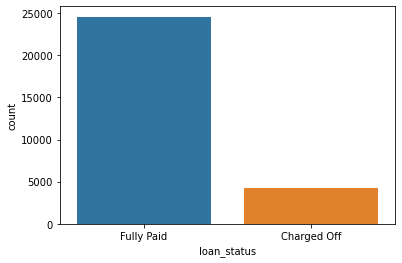

In [55]:
plt_balancing(train_y)

<img src="Immagini\riassunto_bilanciamento.png" width="600"/>

#### SMOTE (Synthetic Minority Oversampling)

E' una delle tecniche di sovra-campionamento piu' utilizzate.

Si basa sulla costruzione di nuove osservazioni della classe minoritaria con caratteristiche simili a quelle esistenti ma del tutto nuove. 

In [56]:
smote = SMOTE(random_state=0, sampling_strategy='not majority', k_neighbors=5, n_jobs=-1)

#train_x, train_y = smote.fit_resample(train_x, train_y)
print(train_x.shape, train_y.shape)
train_x.head()

(28798, 35) (28798, 1)


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
39069,-0.128317,0.084218,0.281806,-0.264197,-0.452252,-0.296965,0.492983,-0.508089,-0.808952,-0.975969,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833
29191,-0.347958,-0.512308,1.638744,1.424483,-0.708629,-0.296965,1.194788,-0.735300,0.120850,-1.355902,...,4.066739,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,1.727971,-0.674833
6560,-0.481802,-0.449552,-1.584322,1.424483,-0.037877,-0.296965,-0.856418,0.173545,0.120850,0.917712,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,1.727971,-0.674833
35167,-0.128317,0.115596,0.644740,-1.108537,0.930986,3.795880,0.704330,-0.508089,1.980455,-0.862288,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,1.481847
4230,-0.866175,-0.794424,0.146383,-0.264197,-0.410517,-0.296965,-0.499655,-1.189722,0.120850,-1.131532,...,-0.245897,7.345612,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833


#### Oversampling

Questo tipo di campionamento aumenta il numero di membri della classe di minoranza nel Training Set.

Tecnica che viene utilizzata quando la quantita' di dati e' bassa: ha il vantaggio che non si perdono informazioni dal set di partenza.

In [57]:
oversampling = RandomOverSampler(sampling_strategy = 'not majority', random_state = 0)

#train_x, train_y = oversampling.fit_resample(train_x, train_y)
print(train_x.shape, train_y.shape)
train_x.head()


(28798, 35) (28798, 1)


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
39069,-0.128317,0.084218,0.281806,-0.264197,-0.452252,-0.296965,0.492983,-0.508089,-0.808952,-0.975969,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833
29191,-0.347958,-0.512308,1.638744,1.424483,-0.708629,-0.296965,1.194788,-0.735300,0.120850,-1.355902,...,4.066739,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,1.727971,-0.674833
6560,-0.481802,-0.449552,-1.584322,1.424483,-0.037877,-0.296965,-0.856418,0.173545,0.120850,0.917712,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,1.727971,-0.674833
35167,-0.128317,0.115596,0.644740,-1.108537,0.930986,3.795880,0.704330,-0.508089,1.980455,-0.862288,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,1.481847
4230,-0.866175,-0.794424,0.146383,-0.264197,-0.410517,-0.296965,-0.499655,-1.189722,0.120850,-1.131532,...,-0.245897,7.345612,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833


#### Undersampling

Questo tipo di campionamento bilancia il dataset riducendo la dimensione della classe maggioritaria.

Scartare alcune osservazioni potrebbe rivelarsi dannoso se si tratta di informazioni utili.

In [58]:
undersampling = RandomUnderSampler(sampling_strategy = 'not minority', random_state = 0)

train_x, train_y = undersampling.fit_resample(train_x, train_y)
print(train_x.shape, train_y.shape)
train_x.head()

(8482, 35) (8482, 1)


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
0,-0.677420,-0.647187,-1.343269,-1.389984,0.632875,-0.296965,0.481628,0.855178,0.120850,-0.552658,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,6.340257,1.727971,-0.674833
1,0.489425,0.802106,0.176176,1.424483,-0.589384,-0.296965,-0.064506,-1.416934,-0.808952,0.279006,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833
2,0.492857,0.754797,-0.240926,-1.108537,-0.112405,-0.296965,0.392254,-1.416934,-0.808952,1.973746,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,1.727971,-0.674833
3,-1.020610,-0.980425,-0.005290,-1.389984,-0.373253,-0.296965,0.681987,-1.189722,-0.808952,-0.983448,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833
4,-1.281435,-1.272871,0.834332,-1.389984,-0.112405,-0.296965,0.972086,-0.053667,1.050653,-1.023834,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833


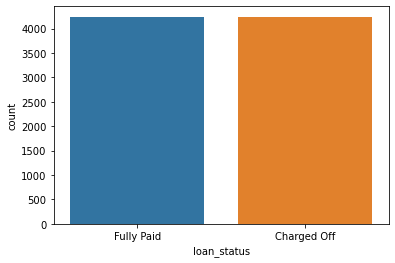

In [59]:
plt_balancing(train_y)

### Riduzione della dimensionalità 

La riduzione della dimensionalità è la pratica di trasformazione dei dati da uno spazio a più alta dimensione ad uno a più bassa dimensione, in modo che l'informazione utile contenuta nei dati si riduca il meno possibile.

La riduzione della dimensionalità in contesti di dati ad alta dimensione $d >> N$ è un'operazione necessaria per poter applicare tantissimi metodi che non sarebbero applicabili altrimenti; nel nostro caso partiamo già da un contesto di dati a bassa dimensione $d << N$, tuttavia può essere ugualmente utile ridurre ulteriormente la dimensionalità dei dati.

Alcuni motivi per cui ha senso effettuare riduzione della dimensionalità anche in contesti di bassa dimensione sono:
1. scegliere di utilizzare un sottoinsieme delle features attualmente disponibili può servire come feedback per alleggerire la fase di raccolta dati;
2. eliminare alcune features permette di avere un dataset più piccolo e dunque rendere le computazioni più rapide;
3. alcuni metodi più elaborati di riduzione della dimensionalità, come la PCA, trasformano le features prima di ridurne il numero, in questo modo si cerca di eliminare la minima quantità di informazione utile a parità di numero di features eliminate;
4. ridurre la dimensionalità permette di contrastare la *curse of dimensionality*: supponiamo che i punti siano uniformemente distribuiti in un ipercubo unitario di dimensione *p* e consideriamo un vicinato che cattura una frazione *f* delle osservazioni; l'ipercubo che cattura una frazione *f* delle osservazioni in uno spazio *p* dimensionale avrà lato $l_{p}=f^{\frac{1}{p}}$. Supponiamo un vicinato che cattura l'1% dei valori, cioè $f=0.01$ e supponiamo di essere in uno spazio relativamente piccolo, $d=10$, allora il lato $l$ dell'ipercubo che in $\mathbb{R}^{10}$ contiene l'1% dei valori, è pari a $l_{10}=0.01^{\frac{1}{10}}\simeq0.63$, mentre il lato dell'ipercubo che contiene tutti i dati è pari a 1.0; questo vuol dire che per catturare l'1% dei dati più vicini in uno spazio a 10 dimensioni, è necessario considerare il 63% dei valori assunti lungo ogni direzione, ma allora questi vicini non sono più così "vicini".<br> Ridurre *p* permette di contrastare questo fenomeno.
<br>L'immagine che segue mostra la distanza da percorrere lungo ogni in funzione della frazioni di punti da voler raggiungere al variare della dimensione p. 

<br><img src="Immagini\curse_of_dimensionality.png" width="600"/><br>L'esempio e l'immagine sono stati presi da [The Elements of Statistical Learning, Hastie-Tibshirani-Friedman, Pag. 22](https://hastie.su.domains/Papers/ESLII.pdf).



#### Principal Component Analysis

In [60]:
dimensionalityReductor = PCA(n_components=0.8)


#### Select K Best

Select K Best seleziona le K migliori features in accordo ad uno score calcolato con una certa funzione.
La funzione utilizzata nel nostro caso è quella di default, cioè l'ANOVA F-Value, calcolata per ciascuna feature contro il target.

L'ANOVA F-Value calcolato su un gruppo di K campioni è il valore della statistica (che assume distribuzione di Fisher):
$$\begin{aligned}
&F=\frac{between-group-variability}{within-group-variability}, \\
&between-group-variability = \frac{\sum_{i=1}^K {n_{i}( \overline Y_{i}- \overline Y)^2}}{K-1} =\\
&within-group-variability = \frac{\sum_{i=1}^K \sum_{j=1}^{n_{i}} {Y_{ij} - \overline Y_{i}}}{N-K}
\end{aligned}$$
Con:
- $\overline Y_{i}$ è la media campionaria dell'i-esimo gruppo;
- $\overline Y$ è la media campionaria tra tutti i dati;
- K è il numero dei gruppi
- $n_{i}$ è il numero di elementi appartenenti all'i-esimo gruppo.
- $N$ è il numero di elementi del dataset
- $Y_{ij}$ è l'elemento j-esimo del gruppo i-esimo.

Nel nostro caso i gruppi sono soltanto 2, in quanto nella procedura si calcolano separatamente gli F-Value relativi alle singole features contro il target.

In [61]:
dimensionalityReductor = SelectKBest(k='all')


#### Forward-Stepwise Selection

La Forward Selection è un tipo di selezione graduale che inizia con un modello vuoto e aggiunge features una per una.

Ad ogni passo si aggiunge l'unica feature che offre il miglioramento maggiore al tuo modello. Il miglioramento è calcolato rispetto a una metrica stabilita.

Una volta che il modello non migliora piu' con l'aggiunta di feature il processo di selezione si interrompe.



In [62]:
#estimator = LogisticRegression(max_iter = 1000, penalty='l2', C=0.1)
#dimensionalityReductor = SequentialFeatureSelector(estimator=estimator, direction="forward", n_jobs=-1, scoring='recall', n_features_to_select=0.5)

In [63]:
print(train_x.shape, test_x.shape)

(8482, 35) (7716, 35)


In [64]:
#CODICE COMUNE AI FEATURE SELECTION METHODS
dimensionalityReductor.fit(train_x, train_y.loan_status)
dataCleaner.set_dimensionalityReductor(dimensionalityReductor)
#train_x = dataCleaner.applyDimensionalityReduction(train_x)
#test_x = dataCleaner.applyDimensionalityReduction(test_x)
train_x.shape
test_x.shape

(7716, 35)

In [65]:
print(train_x.shape, test_x.shape)

(8482, 35) (7716, 35)


## Processamento

### Scelta della metrica 

Il modello verrà utilizzato per determinare chi dovrebbe essere approvato per un prestito e chi no (positivo: prestito da rifiutare, negativo: prestito da accettare)

Negare il prestito a un cliente che finirà per pagarlo per intero (falsi positivi) rappresenta una perdita, ma molto probabilmente l'azienda sarà più a suo agio nel non correre il rischio (richio di non essere rimborsato affatto e perdere l'intero capitale).

Quindi la preoccupazione principale è evitare di approvare qualcuno che non sarà in grado di ripagare (falsi negativi).

Di conseguenza la metrica di valutazione scelta per questo modello è la <b>Recall</b>: $$Recall = TP / (TP + FN)$$
Si deve pero' fare anche attenzione ai <b>FP</b> per assicurarci di non rifiutare troppi mutuatari qualificati.

In [66]:
metric = 'recall'
n_folds = 5
scores_dict = {}
rates_dict = {}

In [67]:
#Plot Feature importance
#---------------------------------------------------------------------------------------
def plot_feature_importances(model,X_train):
    
    xaxes=list(X_train.columns.values)
    yaxes=list(model.best_estimator_.feature_importances_)
    
    h=dict(zip(xaxes,yaxes))
    s = [(k, h[k]) for k in sorted(h, key=h.get, reverse=False)]
    s=dict(s)
    xaxes=list(s.keys())
    yaxes=list(s.values())
    
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), yaxes, align='center') 
    plt.yticks(np.arange(n_features), xaxes) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [68]:
#Function to plot confusion matrix
#------------------------------------------------------------------------------------------------------------------------------
def plot_conf_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [69]:
def plot_classifier_results(model, test_x, test_y):
    print("Miglior iperparametri: ",model.best_params_)
    print("Best Score CV:", model.best_score_)
    y_pred = model.predict(test_x)
    #qualita' della predizione rispetto sul test set
    print(classification_report(test_y, y_pred))
    cnf_matrix = confusion_matrix(test_y, y_pred, labels=model.classes_)
    cm = confusion_matrix(test_y, y_pred, )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_,)
    disp.plot(cmap="Blues")
    return cm


In [70]:
def add_score(model_name, test_y, y_pred, conf_matrix):
    scores_dict[model_name] = {
        'Recall': recall_score(test_y, y_pred),
        'Precision': precision_score(test_y, y_pred),
        'Accuracy': accuracy_score(test_y, y_pred),
        'AUC': roc_auc_score(test_y, y_pred),
        'f1': f1_score(test_y, y_pred),
    }
    #rates 
    TP = np.diag(conf_matrix)[1]
    TN = np.diag(conf_matrix)[0]
    FP = conf_matrix.sum(axis=0)[1] - TP
    FN = conf_matrix.sum(axis=0)[0] - TN
    rates_dict[model_name] = {
        'TPR': TP/(TP+FN),
        'TNR': TN/(TN+FP),
        'FPR': FP/(FP+TN),
        'FNR': FN/(TP+FN),
    }

### Classificazione

Si effettua classificazione binaria rispetto alle classi 'Charged Off' (classe 1) e 'Fully Paid' (classe 0).

I classificatori scelti sono:
- Naive Bayes
- Logistic Regression
- Support Vector Machine (SVM)
- Linear Discriminant Analysis (LDA)
- Quadratic Discriminant Analysis (QDA)
- Random Forest
- Multilayer Perceptron (MLP)
- K-Nearest Neighbors (KNN)
- Adaboost

#### Naive Bayes

              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80      6636
         1.0       0.23      0.53      0.32      1080

    accuracy                           0.69      7716
   macro avg       0.57      0.62      0.56      7716
weighted avg       0.81      0.69      0.73      7716



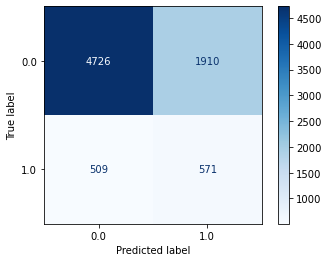

In [71]:
# Naive Bayes
# -------------------------------------------------------------------

nb = GaussianNB()
nb.fit(train_x, train_y.values.ravel())
y_pred = nb.predict(test_x)

print(classification_report(test_y, y_pred))
cm = confusion_matrix(test_y, y_pred, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_,)
disp.plot(cmap="Blues")

add_score('Naive Bayes', test_y, y_pred, cm)


#### Logistic Regression

In [72]:
# Logistic Regression
# -------------------------------------------------------------------
myclassifier = LogisticRegression(solver='liblinear')
params = {'penalty':['l1','l2'], 
          'C':[0.1, 1, 10]}

gscv_lr = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_lr.fit(train_x, train_y.loan_status)  

exception calling callback for <Future at 0x172138488c8 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\_parallel_backends.

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


Miglior iperparametri:  {'C': 0.1, 'penalty': 'l2'}
Best Score CV: 0.6446713114207613
              precision    recall  f1-score   support

         0.0       0.92      0.66      0.77      6636
         1.0       0.24      0.63      0.34      1080

    accuracy                           0.66      7716
   macro avg       0.58      0.65      0.56      7716
weighted avg       0.82      0.66      0.71      7716



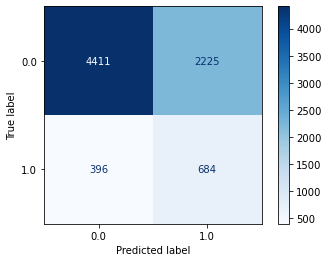

In [ ]:
cm = plot_classifier_results(gscv_lr, test_x, test_y)
add_score('Logistic Regression', test_y, gscv_lr.predict(test_x), cm)

#### Support Vector Machine

In [ ]:
# SVM
# -------------------------------------------------------------------
myclassifier = svm.SVC()
params = {'kernel': ['rbf'], 'gamma':[1e-3], 'C':[1],
            'class_weight':['balanced'], 'tol':[ 1e-4], 'random_state':[0]}

n_folds = 5
gscv_svm = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_svm.fit(train_x, train_y.loan_status)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1], 'class_weight': ['balanced'],
                         'gamma': [0.001], 'kernel': ['rbf'],
                         'random_state': [0], 'tol': [0.0001]},
             scoring='recall')

Miglior iperparametri:  {'C': 1, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'rbf', 'random_state': 0, 'tol': 0.0001}
Best Score CV: 0.5900137786963576
              precision    recall  f1-score   support

         0.0       0.92      0.70      0.79      6636
         1.0       0.25      0.61      0.35      1080

    accuracy                           0.68      7716
   macro avg       0.58      0.65      0.57      7716
weighted avg       0.82      0.68      0.73      7716



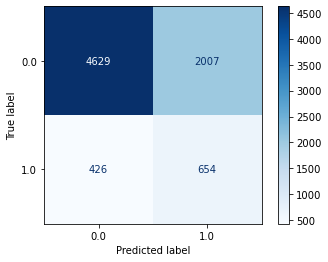

In [ ]:
cm = plot_classifier_results(gscv_svm, test_x, test_y)
add_score('SVM',test_y, gscv_svm.predict(test_x), cm)

#### Linear Discriminant Analysis (LDA)

In [73]:
# Linear Discriminant Analysis
# -------------------------------------------------------------------
myclassifier = LinearDiscriminantAnalysis()
params = {'solver': ['svd', 'lsqr', 'eigen']}

gscv_lda = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_lda.fit(train_x, train_y.loan_status)


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


Miglior iperparametri:  {'solver': 'svd'}
Best Score CV: 0.6371305309242838
              precision    recall  f1-score   support

         0.0       0.92      0.67      0.77      6636
         1.0       0.23      0.63      0.34      1080

    accuracy                           0.66      7716
   macro avg       0.58      0.65      0.56      7716
weighted avg       0.82      0.66      0.71      7716



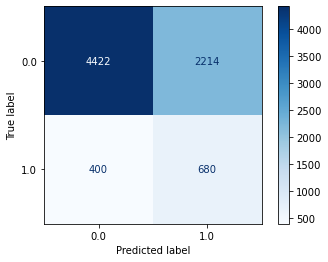

In [ ]:
cm = plot_classifier_results(gscv_lda, test_x, test_y)
add_score('LDA',test_y, gscv_lda.predict(test_x), cm)

#### Quadratic Discriminant Analysis (QDA)

In [74]:
# Quadratic Discriminant Analysis
# -------------------------------------------------------------------
# Importante eliminare la correlazione tra le variabili:
#   la multicollinearita' puo' rendere la predizione inaccurata
myclassifier = QuadraticDiscriminantAnalysis()
params = {'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
            'store_covariance': (True, False),
            'tol': (0.0001, 0.001,0.01, 0.1)}

gscv_qda = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_qda.fit(train_x, train_y.loan_status)

exception calling callback for <Future at 0x1721687a688 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\_parallel_backends.

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


Miglior iperparametri:  {'reg_param': 0.001, 'store_covariance': True, 'tol': 0.0001}
Best Score CV: 0.4938820921394759
              precision    recall  f1-score   support

         0.0       0.90      0.73      0.81      6636
         1.0       0.23      0.49      0.32      1080

    accuracy                           0.70      7716
   macro avg       0.57      0.61      0.56      7716
weighted avg       0.81      0.70      0.74      7716



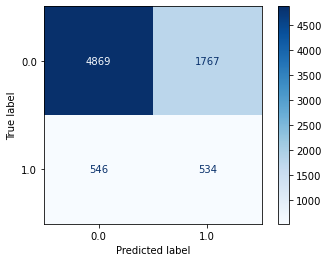

In [ ]:
cm = plot_classifier_results(gscv_qda, test_x, test_y)
add_score('QDA', test_y, gscv_qda.predict(test_x), cm)

#### Random Forest

In [ ]:
# Random Forest
# -------------------------------------------------------------------

myclassifier = RandomForestClassifier(random_state=42)

params = {'criterion' :['gini', 'entropy'],
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,6,8]}

gscv_rf = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_rf.fit(train_x, train_y.loan_status)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             scoring='recall')

In [75]:
cm = plot_classifier_results(gscv_rf, test_x, test_y)
add_score('Random Forest',test_y, gscv_rf.predict(test_x), cm)

NameError: name 'gscv_rf' is not defined

#### Multilayer Perceptron (MLP)

In [76]:
# Multiple Layer Perceptron
# -------------------------------------------------------------------

myclassifier = MLPClassifier(max_iter=100)

params = {'hidden_layer_sizes': [(50,100,50), (100,)],
    'activation': ['tanh'],
    'solver': ['sgd'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['adaptive']}

gscv_mlp = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_mlp.fit(train_x, train_y.loan_status)


exception calling callback for <Future at 0x172140cd788 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\_parallel_backends.

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


Miglior iperparametri:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Best Score CV: 0.6585708491677223
              precision    recall  f1-score   support

         0.0       0.92      0.66      0.76      6636
         1.0       0.23      0.64      0.34      1080

    accuracy                           0.65      7716
   macro avg       0.58      0.65      0.55      7716
weighted avg       0.82      0.65      0.71      7716



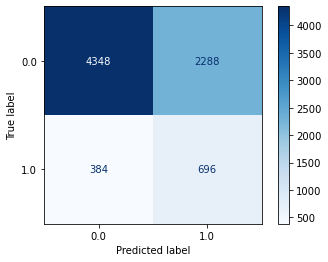

In [ ]:
cm = plot_classifier_results(gscv_mlp, test_x, test_y)
add_score('MLP',test_y, gscv_mlp.predict(test_x), cm)

#### K-nearest neighbors

In [77]:
# KNN
# -------------------------------------------------------------------
myclassifier = KNeighborsClassifier()
params = {'n_neighbors': [3, 5, 7],
         'weights': ['distance'],
         'leaf_size': [30]}
#impossibile parallelizzare knn -> num job = 1
gscv_knn = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=1)

gscv_knn.fit(train_x, train_y.loan_status)
 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'leaf_size': [30], 'n_neighbors': [3, 5, 7],
                         'weights': ['distance']},
             scoring='recall')

Miglior iperparametri:  {'leaf_size': 30, 'n_neighbors': 7, 'weights': 'distance'}
Best Score CV: 0.5656660444029601
              precision    recall  f1-score   support

         0.0       0.90      0.66      0.76      6636
         1.0       0.21      0.57      0.31      1080

    accuracy                           0.65      7716
   macro avg       0.56      0.62      0.54      7716
weighted avg       0.81      0.65      0.70      7716



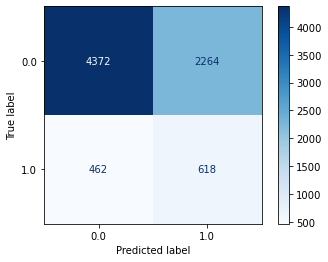

In [78]:
cm = plot_classifier_results(gscv_knn, test_x, test_y)
add_score('KNN',test_y, gscv_knn.predict(test_x), cm)

#### Adaboost

In [79]:
# Adaboost
# -------------------------------------------------------------------
myclassifier = AdaBoostClassifier()
params = {'n_estimators':[200, 500],
         'learning_rate':[.001,0.01,.1]}

gscv_abc = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_abc.fit(train_x, train_y.loan_status)
  

exception calling callback for <Future at 0x17216960348 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\fabia\anaconda3\envs\python37\lib\site-packages\joblib\_parallel_backends.

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


Miglior iperparametri:  {'learning_rate': 0.001, 'n_estimators': 200}
Best Score CV: 0.7351517878969709
              precision    recall  f1-score   support

         0.0       0.93      0.49      0.64      6636
         1.0       0.20      0.76      0.31      1080

    accuracy                           0.53      7716
   macro avg       0.56      0.63      0.48      7716
weighted avg       0.82      0.53      0.60      7716



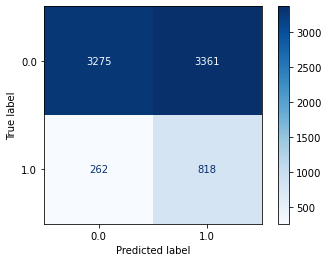

In [ ]:
cm = plot_classifier_results(gscv_abc, test_x, test_y)
add_score('Adaboost',test_y, gscv_abc.predict(test_x), cm)

#### Random forest con matrice di costo

In [ ]:
# Random Forest
# -------------------------------------------------------------------

myclassifier = RandomForestClassifier(random_state=42, class_weight={0:.4,1:.6})

params = {'criterion' :['entropy'],
    'n_estimators': [200, 500],
    'max_features': ['sqrt'],
    'max_depth' : [4,6,8]}

gscv_rf_mc = GridSearchCV(myclassifier, param_grid=params, scoring=metric, cv=n_folds, refit=True, n_jobs=-1)

gscv_rf_mc.fit(train_x, train_y.loan_status)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 0.4, 1: 0.6},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [4, 6, 8],
                         'max_features': ['sqrt'], 'n_estimators': [200, 500]},
             scoring='recall')

Miglior iperparametri:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}
Best Score CV: 0.9179981443207325
              precision    recall  f1-score   support

         0.0       0.96      0.30      0.45      6636
         1.0       0.18      0.93      0.30      1080

    accuracy                           0.39      7716
   macro avg       0.57      0.61      0.38      7716
weighted avg       0.85      0.39      0.43      7716



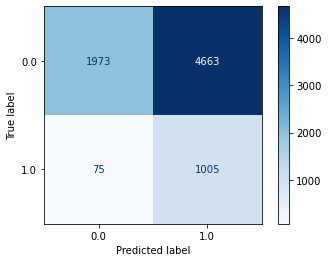

In [ ]:
cm = plot_classifier_results(gscv_rf_mc, test_x, test_y)
add_score('Random Forest (matrice costo)',test_y, gscv_rf_mc.predict(test_x), cm)

#### Born Again Tree

I Born Again Trees sono alberi di decisioni di dimensione minima costruiti a partire da un tree ensemble (ad esempio una random forest, come nel nostro caso) che riproducono esattamente lo stesso comportamento dell'ensemble.

La costruzione del Born Again Tree avviene andando a riprodurre nello spazio delle features lo stesso partizionamento che effettuano complessivamente i singoli alberi che compongono la random forest.

L'uso di Born Again Trees ha il vantaggio che al termine della procedura abbiamo tra le mani un classificatore che gode della robustezza e della capacità di classificazione dell'ensemble da cui siamo partiti e contemporaneamente risulta essere facilmente interpretabile.

Lo svantaggio dei Born Again Trees è che l'algoritmo che li costruisce, dovendo esplorare tutti gli splits effettuati in tutti gli alberi che compongono la foresta, è un algoritmo di programmazione dinamica con complessità esponenziale.

Riferimento: [Born-Again Tree Ensembles](https://arxiv.org/pdf/2003.11132.pdf).<br>
L'implementazione dell'algoritmo è stata presa dalla pagina github degli autori dell'articolo: [vidalt/BA-Trees](https://github.com/vidalt/BA-Trees)


In [80]:
# testare con undersampling e no feature selection
born_again = BornAgainTree()
born_again.setFilename('Loan.csv')
born_again.createRandomForestByCV(train_x, train_y, 3, 10, 'gini', 'sqrt', 5, metric)
born_again.getBornAgainTree(test_x, test_y)

      loan_amnt  installment  int_rate  emp_length  annual_inc  delinq_2yrs  \
0     -0.677420    -0.647187 -1.343269   -1.389984    0.632875    -0.296965   
1      0.489425     0.802106  0.176176    1.424483   -0.589384    -0.296965   
2      0.492857     0.754797 -0.240926   -1.108537   -0.112405    -0.296965   
3     -1.020610    -0.980425 -0.005290   -1.389984   -0.373253    -0.296965   
4     -1.281435    -1.272871  0.834332   -1.389984   -0.112405    -0.296965   
...         ...          ...       ...         ...         ...          ...   
8477   0.558063     0.021316 -0.333014    1.424483    0.124594    -0.296965   
8478  -0.128317     0.098893  0.452439    0.017250    0.060500     1.749457   
8479  -0.677420    -0.600843 -0.408851    1.424483   -0.559573     1.749457   
8480  -0.677420    -0.578589  0.029920    1.424483   -0.097499     3.795880   
8481  -0.814696    -0.687110  1.224350   -1.389984   -0.186993    -0.296965   

      earliest_cr_line  open_acc  inq_last_6mths   

OSError: [WinError 193] %1 non è un'applicazione di Win32 valida

              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81      6636
         1.0       0.25      0.57      0.35      1080

    accuracy                           0.70      7716
   macro avg       0.58      0.65      0.58      7716
weighted avg       0.82      0.70      0.74      7716



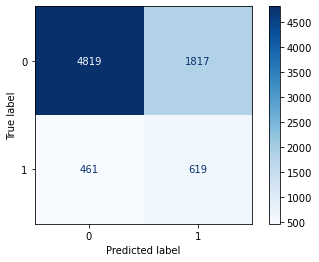

In [ ]:
y_pred = born_again.predict(test_x)

print(classification_report(test_y, y_pred))
cm = confusion_matrix(test_y, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
add_score('BornAgainTree',test_y, born_again.predict(test_x), cm)

#### Euristica per la pipeline ottima

A vincere non è l'algoritmo di addestramento, ma l'intera pipeline, cioè l'intera sequenza di processamenti che vengono effettuati sui dati: non esiste "il miglior modo per effettuare feature selection" o "il miglior classificatore in assoluto".

Detto ciò, avendo diverse alternative per ciascuna fase della pipeline, un modo per selezionare la pipeline ottima è tramite un algoritmo brute-force: per ogni fase della pipeline si considerano tutte le possibili alternative al variare di tutte le possibili alternative per tutte le altre fasi.

Come in altri contesti dell'ingegneria e dell'ottimizzazione, questo approccio risulta impraticabile il più delle volte perché comporterebbe dei tempi di elaborazione troppo elevati a casua della quantità di alternative esplorate.

Per risolvere questo problema, abbiamo ideato un'euristica greedy iterativa che funziona come segue: ad ogni iterazione cerca l'alternativa migliore per una fase della pipeline alla volta, avendo fissato le alternativa per le altre fasi, se durante un'iterazione non si effettua alcun cambiamento, l'algoritmo termina, altrimenti continua fino ad un numero massimo K di iterazioni stabilito a priori.

Evidentemente questo algoritmo non fornisce la soluzione ottima, ma una soluzione subottimale.

Uno pseudocodice dell'algoritmo è:
1. si fissa il numero massimo di iterazioni K dell'algoritmo <br>
2. si stabilisce per ogni fase della pipeline un alternativa da utilizzare (inizializzazione) <br>
3. for i = 1 ... K <br>
    3.2 per ogni fase J della pipeline <br>
        &emsp;3.2.1 scegli la migliore alternativa per la fase J, avendo fissato le scelte per le altre fasi <br>
    3.3 if per nessuna fase ho cambiato l'alternativa scelta <br>
        &emsp;3.3.1 break <br>
4. restituisci la pipeline ottenuta <br>


La nostra implementazione prevede di ottimizzare scegliendo diverse alternative per:
- resampling dei dati
- riduzione della dimensionalita'
- classificazione


In [81]:
"""
Funzione che verifica che obj1 e obj2 abbiano gli stessi valori degli attributi.
obj1 e ob2 sono due oggetti che appartengono alla stessa classe.
Il parametro isClassifier è True se gli oggetti sono classificatori, False altrimenti.
listOfDict è la lista dei classificatori se isClassifier è true, mentre la lista dei metodi di riduzione della dimensionalità altrimenti.
"""
def haveSameAttributeValues(listOfDict, obj1, obj2, isClassifier):
    #In base a isClassifier settiamo itemKey='classifier' o itemKey='dim_reductor'
    itemKey = None
    if(isClassifier):
        itemKey = 'classifier'
    else: #è un dimensionality reductor
        itemKey = 'dim_reductor'


    listOfAttributes = []
    for elem in listOfDict:
        # elem[itemKey][0] è il classificatore/dim_reductor
        # elem['params'] è un dizionario che contiene gli attributi (chiavi) e i valori che testiamo per il classificatore/dim_reductor 
        # ci interessano solo le chiavi, cioè i valori degli attributi
        if type(elem[itemKey][0]).__name__==type(obj1).__name__:
            listOfAttributes = list(elem['params'].keys())

    #se esiste un attributo per cui gli oggetti hanno valori diversi, allora ritorniamo False, altrimenti True
    for attribute in listOfAttributes:
        if getattr(obj1, attribute) != getattr(obj2, attribute):
            return False
    return True    

In [ ]:

phases = ['classifier', 'reduce_dim', 'balancing']
dict_NB = {
    'classifier': [GaussianNB()],
    'params':{}
}
dict_LR = {
    'classifier': [LogisticRegression(solver='liblinear')],
    'params': {'penalty':['l1'], 
            'C':[0.1, 1, 10]}
}
dict_SVM = {
    'classifier':[svm.SVC()],
    'params': {'kernel': ['rbf'], 
    'gamma':['scale','auto'], 
    'C':[0.1,1,10], 
    'class_weight':['balanced'], 
    'tol':[ 1e-4], 
    'random_state':[0]}
}
dict_RF = {
    'classifier':[RandomForestClassifier()],
    'params': {'criterion' :['gini', 'entropy'],
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,6,8],
    'n_jobs':[-1],
    'random_state':[0]}
}
dict_MLP = {
    'classifier': [MLPClassifier(max_iter=200)],
    'params' : {'hidden_layer_sizes': [(50,100,50), (100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.05],
    'learning_rate': ['adaptive']}
}
dict_KNN ={
    'classifier' : [KNeighborsClassifier()],
    'params': {'n_neighbors': [3, 5, 7],
         'weights': ['distance'],
         'n_jobs':[-1],
         'leaf_size': [30]}
}
dict_ADABoost = {
    'classifier': [AdaBoostClassifier()],
    'params':{'n_estimators':[500,1000,2000],
         'learning_rate':[0.001,0.01,0.1],
         'random_state':[0]}
}

classifierList = [dict_NB, dict_LR, dict_SVM, dict_RF, dict_MLP, dict_KNN, dict_ADABoost]


dict_SelectKBest = {
    'dim_reductor': [SelectKBest()],
    'params': {
        'k':[25,'all']
    }
}
dict_StepForward = {
    'dim_reductor': [SequentialFeatureSelector(LogisticRegression())],
    'params': {
        'n_features_to_select': [0.5,0.8],
        'n_jobs': [-1]
    }
}
dict_PCA ={
    'dim_reductor': [PCA()],
    'params': {
        'n_components': [0.8,0.9],
        'random_state':[0]
    }
}

dim_reductorList = [dict_SelectKBest, dict_StepForward, dict_PCA]


resamplingMethodsList = [None, RandomUnderSampler(random_state=0, sampling_strategy='not minority'), RandomOverSampler(random_state=0, sampling_strategy='not majority'), SMOTE(random_state=0, sampling_strategy='not majority', n_jobs=-1)]

variablePhases =['classifying', 'dim_reduction', 'sampling']
bestResampler = None
bestDimReductor = SelectKBest(k='all')
bestClassifier = LogisticRegression()

#mi mantengo una copia vergine dei dati
train_x_pre_resample, train_y_pre_resample = train_x, train_y

#contatore per contare 3 fasi consecutive in variablePhases in cui non abbiamo cambiato nulla
counterCheck = 0

for round in range(0, 4): #il termine di questo range è un parametro che possiamo scegliere e che determina quante volte iterare
    for phase in variablePhases:
        if counterCheck == 3:
            break
        if phase=='classifying': #variamo il classificatore
            if bestResampler != None:
                train_x, train_y = bestResampler.fit_resample(train_x_pre_resample, train_y_pre_resample)
            else:
                train_x, train_y = train_x_pre_resample, train_y_pre_resample
            pipeline = [
            ('dim_reductor', bestDimReductor),
            ('classifier', bestClassifier)]

            paramList = []
            for elem in classifierList:
                dict_for_elem = {
                    'dim_reductor': [bestDimReductor],
                    'classifier': elem['classifier']
                }
                for param in elem['params']:
                    dict_for_elem['classifier__'+param] = elem['params'][param]
                paramList.append(dict_for_elem)
             
            pipe = Pipeline(pipeline)
            gscv = GridSearchCV(pipe, param_grid=paramList, scoring='recall', n_jobs=-1, cv=n_folds, refit=True)
            gscv.fit(train_x, train_y)

            print("classifier round", round)
            print("best resampler", type(bestResampler).__name__)
            print(gscv.best_params_)
            if type(gscv.best_params_['classifier']).__name__==type(bestClassifier).__name__:
                if haveSameAttributeValues(classifierList, gscv.best_params_['classifier'], bestClassifier, True):
                    print(counterCheck, " -> ", counterCheck+1)
                    counterCheck = counterCheck + 1
            else:
                print(counterCheck, " -> ", 0)
                counterCheck = 0
            bestClassifier = gscv.best_params_['classifier']
        elif phase=='dim_reduction':
            if bestResampler != None:
                train_x, train_y = bestResampler.fit_resample(train_x_pre_resample, train_y_pre_resample)
            else:
                train_x, train_y = train_x_pre_resample, train_y_pre_resample
            pipeline = [
            ('dim_reductor', bestDimReductor),
            ('classifier', bestClassifier)]

            paramList = []
            for elem in dim_reductorList:
                dict_for_elem = {
                    'dim_reductor': elem['dim_reductor'],
                    'classifier': [bestClassifier]
                }
                for param in elem['params']:
                    dict_for_elem['dim_reductor__'+param] = elem['params'][param]
                paramList.append(dict_for_elem)
            
            pipe = Pipeline(pipeline)
            gscv = GridSearchCV(pipe, param_grid=paramList, scoring='recall', n_jobs=-1, cv=n_folds, refit=True)
            gscv.fit(train_x, train_y)
            print("dim_reduction round", round)
            print("best resampler", type(bestResampler).__name__)
            print(gscv.best_params_)
            if type(gscv.best_params_['dim_reductor']).__name__==type(bestDimReductor).__name__:
                if haveSameAttributeValues(dim_reductorList, gscv.best_params_['dim_reductor'], bestDimReductor, False):
                    print(counterCheck, " -> ", counterCheck+1)
                    counterCheck = counterCheck + 1
            else:
                print(counterCheck, " -> ", 0)
                counterCheck = 0
            bestDimReductor = gscv.best_params_['dim_reductor']
        else: #phase == 'sampling'
            scores = []
            for indexResampler in range(0,len(resamplingMethodsList)):
                resampler = resamplingMethodsList[indexResampler]
                if resampler != None:
                    train_x, train_y = resampler.fit_resample(train_x_pre_resample, train_y_pre_resample)
                else:
                    train_x, train_y = train_x_pre_resample, train_y_pre_resample
                pipeline = [
                ('dim_reductor', bestDimReductor),
                ('classifier', bestClassifier)]

                paramList = [{'dim_reductor': [bestDimReductor], 'classifier':[bestClassifier]}]

                pipe = Pipeline(pipeline)
                gscv = GridSearchCV(pipe, param_grid=paramList, scoring='recall', n_jobs=-1, cv=n_folds, refit=True)
                gscv.fit(train_x, train_y)
                scores.append((indexResampler, gscv.best_score_, gscv.best_params_))
            max = -1
            best = {}
            bestIndex = -1
            for scoreIndex in range(0, len(scores)):
                if scores[scoreIndex][1]>max:
                    bestIndex = scoreIndex
            
            print("resampling round", round)
            print(scores[bestIndex][2])
            print("new resampler", type(resamplingMethodsList[bestIndex]).__name__)
            if type(resamplingMethodsList[bestIndex]).__name__==type(bestResampler).__name__:
                print(counterCheck, " -> ", counterCheck+1)
                counterCheck = counterCheck + 1
            else:
                print(counterCheck, " -> ", 0)
                counterCheck = 0
            bestResampler = resamplingMethodsList[bestIndex]




/home/valerio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/valerio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/valerio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/valerio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/valerio/anaconda3/lib/python3.

classifier round 0
best resampler NoneType
{'classifier': AdaBoostClassifier(learning_rate=0.001, n_estimators=500, random_state=0), 'classifier__learning_rate': 0.001, 'classifier__n_estimators': 500, 'classifier__random_state': 0, 'dim_reductor': SelectKBest(k='all')}
0  ->  0
dim_reduction round 0
best resampler NoneType
{'classifier': AdaBoostClassifier(learning_rate=0.001, n_estimators=500, random_state=0), 'dim_reductor': PCA(n_components=0.8, random_state=0), 'dim_reductor__n_components': 0.8, 'dim_reductor__random_state': 0}
0  ->  0
resampling round 0
{'classifier': AdaBoostClassifier(learning_rate=0.001, n_estimators=500, random_state=0), 'dim_reductor': PCA(n_components=0.8, random_state=0)}
new resampler SMOTE
0  ->  0


/home/valerio/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/valerio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/valerio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/valerio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/valerio/ana

classifier round 1
best resampler SMOTE
{'classifier': AdaBoostClassifier(learning_rate=0.001, n_estimators=500, random_state=0), 'classifier__learning_rate': 0.001, 'classifier__n_estimators': 500, 'classifier__random_state': 0, 'dim_reductor': PCA(n_components=0.8, random_state=0)}
0  ->  1
dim_reduction round 1
best resampler SMOTE
{'classifier': AdaBoostClassifier(learning_rate=0.001, n_estimators=500, random_state=0), 'dim_reductor': PCA(n_components=0.8, random_state=0), 'dim_reductor__n_components': 0.8, 'dim_reductor__random_state': 0}
1  ->  2
resampling round 1
{'classifier': AdaBoostClassifier(learning_rate=0.001, n_estimators=500, random_state=0), 'dim_reductor': PCA(n_components=0.8, random_state=0)}
new resampler SMOTE
2  ->  3


In [ ]:
bestResampler

SMOTE(n_jobs=-1, random_state=0, sampling_strategy='not majority')

In [ ]:
smote = SMOTE(random_state=0, sampling_strategy='not majority', n_jobs=-1)

train_x, train_y = smote.fit_resample(train_x, train_y)
print(train_x.shape, train_y.shape)
train_x.head()

(8482, 35) (8482,)


,loan_amnt,installment,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,open_acc,inq_last_6mths,dti,...,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Source Verified,x3_Verified
0,-0.677420,-0.647187,-1.343269,-1.389984,0.632875,-0.296965,0.481628,0.855178,0.120850,-0.552658,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,6.340257,1.727971,-0.674833
1,0.489425,0.802106,0.176176,1.424483,-0.589384,-0.296965,-0.064506,-1.416934,-0.808952,0.279006,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833
2,0.492857,0.754797,-0.240926,-1.108537,-0.112405,-0.296965,0.392254,-1.416934,-0.808952,1.973746,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,1.727971,-0.674833
3,-1.020610,-0.980425,-0.005290,-1.389984,-0.373253,-0.296965,0.681987,-1.189722,-0.808952,-0.983448,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833
4,-1.281435,-1.272871,0.834332,-1.389984,-0.112405,-0.296965,0.972086,-0.053667,1.050653,-1.023834,...,-0.245897,-0.136136,-0.124993,-0.334951,-0.05278,-0.218828,-0.100154,-0.157722,-0.578714,-0.674833


In [ ]:
bestDimReductor

PCA(n_components=0.8, random_state=0)

In [ ]:
dimensionalityReductor = PCA(n_components=0.8, random_state=0)
dimensionalityReductor.fit(train_x, train_y)
dataCleaner.set_dimensionalityReductor(dimensionalityReductor)
train_x = dataCleaner.applyDimensionalityReduction(train_x)
test_x = dataCleaner.applyDimensionalityReduction(test_x)
print(train_x.shape, test_x.shape)

(8482, 21) (7716, 21)


In [ ]:
bestClassifier

AdaBoostClassifier(learning_rate=0.001, n_estimators=500, random_state=0)

              precision    recall  f1-score   support

         0.0       0.92      0.36      0.52      6636
         1.0       0.17      0.81      0.28      1080

    accuracy                           0.42      7716
   macro avg       0.55      0.59      0.40      7716
weighted avg       0.82      0.42      0.48      7716

Confusion matrix, without normalization
[[2387 4249]
 [ 202  878]]


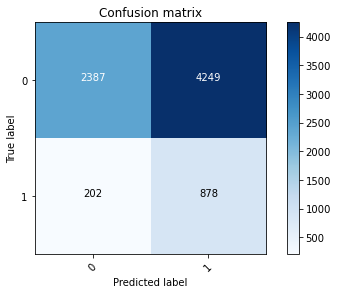

In [ ]:
bestClassifier.fit(train_x, train_y)
y_pred = bestClassifier.predict(test_x)
#qualita' della predizione rispetto sul test set
print(classification_report(test_y, y_pred))
cm = confusion_matrix(test_y, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")

add_score('Euristica ottima',test_y, bestClassifier.predict(test_x), cm)

## Conclusione

### Comparazione dei modelli

In [131]:
scores_df = pd.DataFrame(scores_dict)
metrics_plot = scores_df.hvplot.barh(
    width=1000, height=1200, 
    title="Scores of ML Models", xlabel="Scores", 
    alpha=0.4, legend='top'
)
metrics_plot

:Bars   [index,Variable]   (value)

In [132]:
scores_df_T = pd.DataFrame(scores_dict).T
rate_df_T = pd.DataFrame(rates_dict).T
results_df = pd.concat([scores_df_T, rate_df_T], axis=1)
results_df

,Recall,Precision,Accuracy,AUC,f1,TPR,TNR,FPR,FNR
Naive Bayes,0.473148,0.231851,0.706843,0.609012,0.311206,0.473148,0.744876,0.255124,0.526852
Logistic Regression,0.633333,0.235132,0.660316,0.649020,0.342943,0.633333,0.664708,0.335292,0.366667
SVM,0.605556,0.245772,0.684681,0.651557,0.349639,0.605556,0.697559,0.302441,0.394444
LDA,0.629630,0.234969,0.661223,0.647997,0.342224,0.629630,0.666365,0.333635,0.370370
QDA,0.494444,0.232073,0.700233,0.614085,0.315883,0.494444,0.733725,0.266275,0.505556
Random Forest,0.692593,0.261447,0.683126,0.687089,0.379599,0.692593,0.681585,0.318415,0.307407
MLP,0.644444,0.233244,0.653707,0.649829,0.342520,0.644444,0.655214,0.344786,0.355556
KNN,0.570370,0.210095,0.639710,0.610682,0.307079,0.570370,0.650995,0.349005,0.429630
Adaboost,0.757407,0.195741,0.530456,0.625464,0.311086,0.757407,0.493520,0.506480,0.242593
Random Forest (matrice costo),0.930556,0.177311,0.385951,0.613937,0.297866,0.930556,0.297318,0.702682,0.069444


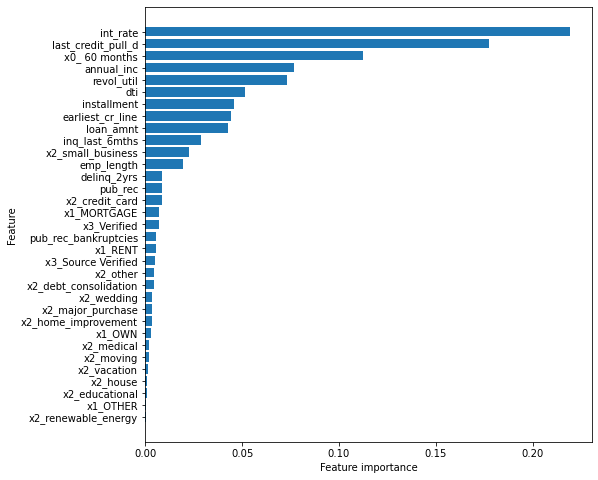

In [133]:
# per uno dei modelli migliori
model = gscv_rf
plot_feature_importances(model,train_x)